## ANLY590 Deep Learning Project- Animal Classification
### Heng Zhou, Hongyang Zheng, Youyou Xie, Zhengqian Xu

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
# import cv2
import os
import h5py
import PIL
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

from skimage import io, transform
from skimage.transform import resize
#from imgaug import augmenters as iaa
from tqdm import tqdm
from PIL import Image, ImageOps

from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


## 1. Read Image and Transform into Array

In [3]:
# Load data 
def get_data(folder_path):
    
    foldernames = ['cavallo','mucca','pecora']
    imgs = []
    indices = []
    labels = []
    img_size = 100
    
    for idx, folder_name in enumerate(foldernames): 
        labels.append(folder_name)
        
        for file_name in tqdm(os.listdir(folder_path + '/' + folder_name)):
            
            if file_name.endswith('jpeg'):
                img_file = io.imread(folder_path + '/' +  folder_name + '/' + file_name)
                
                # Transform image into numpy array
                if img_file is not None:
                    img_file = transform.resize(img_file, (img_size, img_size))
                    imgs.append(np.asarray(img_file))
                    indices.append(idx)
    
    imgs = np.asarray(imgs)
    indices = np.asarray(indices).reshape(-1,1)
    labels = np.asarray(labels)
    
    return imgs, indices, labels
    
    
X, y, labels = get_data('./raw-img')    
print('X shape:', X.shape)
print('y shape:', y.shape)
print("labels:",labels)

100%|█████████████████████████████████████████████████████████████████████████████| 1942/1942 [00:16<00:00, 116.53it/s]


X shape: (6270, 100, 100, 3)
y shape: (6270, 1)
labels: ['cavallo' 'mucca' 'pecora']


## 2. Visualization for Three Selected Animals - Sheep, Cow, Horse

0    2672
1    2039
2    1559
Name: label, dtype: int64

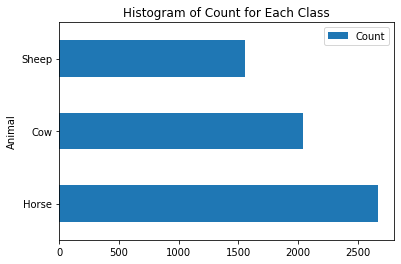

In [4]:
# Create labels
dfy = pd.DataFrame(y).rename({0:'label'},axis=1)
dfy['label'].value_counts()

# Histogram of count for each class
df = pd.DataFrame({'Animal':['Horse', 'Cow', 'Sheep'], 'Count': dfy['label'].value_counts().tolist()})
ax = df.plot.barh(x='Animal', y='Count', title = 'Histogram of Count for Each Class')

There are 2672 horse images, 2039 cow images and 1559 sheep images.

From here we can see that the class is not balanced.

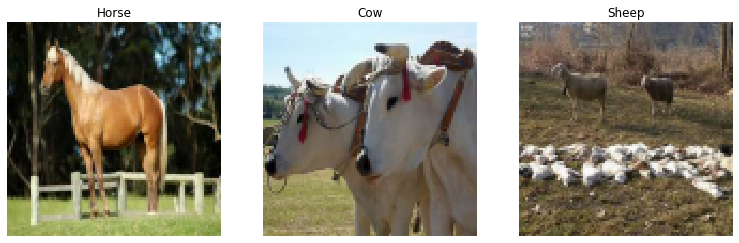

In [9]:
img_size = 100

# Display the data
plt.figure(figsize=(13,13))
plt.subplot(1, 3, 1)
plt.imshow(X[1].reshape(img_size, img_size,3))
plt.title('Horse')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X[2900].reshape(img_size, img_size,3))
plt.title('Cow')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(X[6000].reshape(img_size, img_size,3))
plt.title('Sheep')
plt.axis('off')
plt.show()

From here we can see that some images can be hard to classify such as the cow and sheep with the same color.

## 3.  Model Training and Evaluation

In [34]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [35]:
# Turn y_label into one-hot encoding
num_classes = 3
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [12]:
# Reshape the data for ANN
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

x_train_ann = X_train.reshape(number_of_train,  X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
x_test_ann = X_test.reshape(number_of_test,  X_test.shape[1]*X_test.shape[2]* X_test.shape[3])
y_train_ann = y_train_cat
y_test_ann = y_test_cat

# Print out the shape of data
print('x train: ', x_train_ann.shape)
print('x test: ', x_test_ann.shape)
print('y train: ', y_train_ann.shape)
print('y test: ', y_test_ann.shape)

x train:  (5016, 30000)
x test:  (1254, 30000)
y train:  (5016, 3)
y test:  (1254, 3)


### 1. ANN

We will first try ANN with 2 layers.  

__ANN 1__:
1. Layer 1: has 8 nodes, using `relu` activation function.
2. Layer 2: has 3 nodes, using `softmax` activation function for multi-class prediction.  

In [15]:
# Create ANN model to fit

def ann_layer2():  
    # Initialize neural network
    classifier = Sequential() 
    
    # Add layers
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_ann.shape[1]))
    classifier.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
    
    # Define optimizer and loss function
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
    
    return classifier

# Training the model
classifier = KerasClassifier(build_fn = ann_layer2, epochs = 100)
results = cross_val_score(estimator = classifier, X = x_train_ann, y = y_train_ann, cv = 2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/100
2508/2508 [==============================] - ETA: 34s - loss: 1.0984 - accuracy: 0.312 - ETA: 19s - loss: 1.1035 - accuracy: 0.312 - ETA: 10s - loss: 1.1141 - accuracy: 0.265 - ETA: 7s - loss: 1.1088 - accuracy: 0.286 - ETA: 6s - loss: 1.1067 - accuracy: 0.31 - ETA: 5s - loss: 1.1048 - accuracy: 0.34 - ETA: 4s - loss: 1.1037 - accuracy: 0.34 - ETA: 4s - loss: 1.1023 - accuracy: 0.36 - ETA: 3s - loss: 1.1021 - accuracy: 0.36 - ETA: 3s - loss: 1.1013 - accuracy: 0.37 - ETA: 3s - loss: 1.1007 - accuracy: 0.38 - ETA: 2s - loss: 1.0994 - accuracy: 0.40 - ETA: 2s - loss: 1.0990 - accuracy: 0.40 - ETA: 2s - loss: 1.0992 - accuracy: 0.40 - ETA: 2s - loss: 1.0990 - accuracy: 0.40 - ETA: 1s - loss: 1.0988 - accuracy: 0.40 - ETA: 1s - loss: 1.0984 - accuracy: 0.40 - ETA: 1s - loss: 1.0982 - accuracy: 0.41 - ETA: 1s - loss: 1.0981 - accuracy: 0.40 - ETA: 1s - loss: 1.0976 - accuracy: 0.41 - ETA: 1s - loss

2508/2508 [==============================] - ETA: 1s - loss: 1.0804 - accuracy: 0.40 - ETA: 1s - loss: 1.0763 - accuracy: 0.39 - ETA: 1s - loss: 1.0775 - accuracy: 0.39 - ETA: 1s - loss: 1.0751 - accuracy: 0.40 - ETA: 0s - loss: 1.0724 - accuracy: 0.41 - ETA: 0s - loss: 1.0664 - accuracy: 0.43 - ETA: 0s - loss: 1.0711 - accuracy: 0.43 - ETA: 0s - loss: 1.0707 - accuracy: 0.43 - ETA: 0s - loss: 1.0733 - accuracy: 0.42 - ETA: 0s - loss: 1.0732 - accuracy: 0.42 - ETA: 0s - loss: 1.0744 - accuracy: 0.42 - ETA: 0s - loss: 1.0745 - accuracy: 0.42 - ETA: 0s - loss: 1.0739 - accuracy: 0.42 - ETA: 0s - loss: 1.0738 - accuracy: 0.42 - ETA: 0s - loss: 1.0762 - accuracy: 0.41 - ETA: 0s - loss: 1.0731 - accuracy: 0.42 - ETA: 0s - loss: 1.0728 - accuracy: 0.42 - ETA: 0s - loss: 1.0724 - accuracy: 0.42 - ETA: 0s - loss: 1.0713 - accuracy: 0.42 - ETA: 0s - loss: 1.0701 - accuracy: 0.42 - 1s 459us/step - loss: 1.0699 - accuracy: 0.4290
Epoch 14/100
2508/2508 [==============================] - ETA: 1s -

2508/2508 [==============================] - ETA: 1s - loss: 1.1146 - accuracy: 0.31 - ETA: 1s - loss: 1.0696 - accuracy: 0.40 - ETA: 1s - loss: 1.0915 - accuracy: 0.35 - ETA: 1s - loss: 1.0897 - accuracy: 0.36 - ETA: 0s - loss: 1.0845 - accuracy: 0.39 - ETA: 0s - loss: 1.0778 - accuracy: 0.40 - ETA: 0s - loss: 1.0730 - accuracy: 0.41 - ETA: 0s - loss: 1.0736 - accuracy: 0.41 - ETA: 0s - loss: 1.0711 - accuracy: 0.42 - ETA: 0s - loss: 1.0695 - accuracy: 0.43 - ETA: 0s - loss: 1.0700 - accuracy: 0.42 - ETA: 0s - loss: 1.0695 - accuracy: 0.43 - ETA: 0s - loss: 1.0674 - accuracy: 0.43 - ETA: 0s - loss: 1.0685 - accuracy: 0.43 - ETA: 0s - loss: 1.0687 - accuracy: 0.43 - ETA: 0s - loss: 1.0692 - accuracy: 0.43 - ETA: 0s - loss: 1.0686 - accuracy: 0.43 - ETA: 0s - loss: 1.0694 - accuracy: 0.43 - ETA: 0s - loss: 1.0689 - accuracy: 0.43 - ETA: 0s - loss: 1.0688 - accuracy: 0.43 - ETA: 0s - loss: 1.0698 - accuracy: 0.42 - 1s 468us/step - loss: 1.0699 - accuracy: 0.4290
Epoch 28/100
2508/2508 [=

2508/2508 [==============================] - ETA: 1s - loss: 1.0895 - accuracy: 0.28 - ETA: 1s - loss: 1.0452 - accuracy: 0.46 - ETA: 1s - loss: 1.0837 - accuracy: 0.39 - ETA: 1s - loss: 1.0827 - accuracy: 0.39 - ETA: 0s - loss: 1.0850 - accuracy: 0.40 - ETA: 0s - loss: 1.0835 - accuracy: 0.41 - ETA: 0s - loss: 1.0815 - accuracy: 0.41 - ETA: 1s - loss: 1.0810 - accuracy: 0.41 - ETA: 1s - loss: 1.0806 - accuracy: 0.41 - ETA: 0s - loss: 1.0777 - accuracy: 0.41 - ETA: 0s - loss: 1.0766 - accuracy: 0.41 - ETA: 0s - loss: 1.0732 - accuracy: 0.42 - ETA: 0s - loss: 1.0742 - accuracy: 0.41 - ETA: 0s - loss: 1.0732 - accuracy: 0.42 - ETA: 0s - loss: 1.0714 - accuracy: 0.42 - ETA: 0s - loss: 1.0693 - accuracy: 0.42 - ETA: 0s - loss: 1.0690 - accuracy: 0.42 - ETA: 0s - loss: 1.0695 - accuracy: 0.42 - ETA: 0s - loss: 1.0711 - accuracy: 0.42 - ETA: 0s - loss: 1.0710 - accuracy: 0.42 - ETA: 0s - loss: 1.0701 - accuracy: 0.42 - ETA: 0s - loss: 1.0711 - accuracy: 0.42 - ETA: 0s - loss: 1.0693 - accura

2508/2508 [==============================] - ETA: 1s - loss: 1.1071 - accuracy: 0.34 - ETA: 1s - loss: 1.0712 - accuracy: 0.44 - ETA: 1s - loss: 1.0639 - accuracy: 0.42 - ETA: 1s - loss: 1.0610 - accuracy: 0.44 - ETA: 0s - loss: 1.0546 - accuracy: 0.46 - ETA: 0s - loss: 1.0690 - accuracy: 0.42 - ETA: 0s - loss: 1.0692 - accuracy: 0.42 - ETA: 0s - loss: 1.0669 - accuracy: 0.43 - ETA: 0s - loss: 1.0647 - accuracy: 0.43 - ETA: 0s - loss: 1.0646 - accuracy: 0.43 - ETA: 0s - loss: 1.0619 - accuracy: 0.43 - ETA: 0s - loss: 1.0618 - accuracy: 0.44 - ETA: 0s - loss: 1.0616 - accuracy: 0.44 - ETA: 0s - loss: 1.0637 - accuracy: 0.43 - ETA: 0s - loss: 1.0637 - accuracy: 0.44 - ETA: 0s - loss: 1.0652 - accuracy: 0.43 - ETA: 0s - loss: 1.0648 - accuracy: 0.44 - ETA: 0s - loss: 1.0680 - accuracy: 0.43 - ETA: 0s - loss: 1.0721 - accuracy: 0.42 - ETA: 0s - loss: 1.0721 - accuracy: 0.42 - ETA: 0s - loss: 1.0720 - accuracy: 0.42 - ETA: 0s - loss: 1.0704 - accuracy: 0.43 - ETA: 0s - loss: 1.0694 - accura

2508/2508 [==============================] - ETA: 1s - loss: 1.1338 - accuracy: 0.18 - ETA: 1s - loss: 1.1134 - accuracy: 0.33 - ETA: 1s - loss: 1.0921 - accuracy: 0.36 - ETA: 1s - loss: 1.0830 - accuracy: 0.37 - ETA: 1s - loss: 1.0774 - accuracy: 0.37 - ETA: 1s - loss: 1.0756 - accuracy: 0.39 - ETA: 1s - loss: 1.0690 - accuracy: 0.40 - ETA: 1s - loss: 1.0646 - accuracy: 0.42 - ETA: 1s - loss: 1.0619 - accuracy: 0.42 - ETA: 1s - loss: 1.0648 - accuracy: 0.42 - ETA: 1s - loss: 1.0634 - accuracy: 0.43 - ETA: 1s - loss: 1.0630 - accuracy: 0.43 - ETA: 1s - loss: 1.0645 - accuracy: 0.43 - ETA: 1s - loss: 1.0656 - accuracy: 0.43 - ETA: 0s - loss: 1.0650 - accuracy: 0.43 - ETA: 0s - loss: 1.0701 - accuracy: 0.43 - ETA: 0s - loss: 1.0728 - accuracy: 0.42 - ETA: 0s - loss: 1.0757 - accuracy: 0.42 - ETA: 0s - loss: 1.0759 - accuracy: 0.42 - ETA: 0s - loss: 1.0736 - accuracy: 0.42 - ETA: 0s - loss: 1.0713 - accuracy: 0.43 - ETA: 0s - loss: 1.0710 - accuracy: 0.43 - ETA: 0s - loss: 1.0711 - accura

2508/2508 [==============================] - ETA: 1s - loss: 1.0618 - accuracy: 0.53 - ETA: 1s - loss: 1.0685 - accuracy: 0.46 - ETA: 1s - loss: 1.0619 - accuracy: 0.46 - ETA: 1s - loss: 1.0692 - accuracy: 0.43 - ETA: 0s - loss: 1.0620 - accuracy: 0.44 - ETA: 0s - loss: 1.0644 - accuracy: 0.43 - ETA: 0s - loss: 1.0683 - accuracy: 0.43 - ETA: 0s - loss: 1.0691 - accuracy: 0.43 - ETA: 0s - loss: 1.0628 - accuracy: 0.43 - ETA: 0s - loss: 1.0631 - accuracy: 0.44 - ETA: 0s - loss: 1.0624 - accuracy: 0.44 - ETA: 0s - loss: 1.0667 - accuracy: 0.43 - ETA: 0s - loss: 1.0671 - accuracy: 0.43 - ETA: 0s - loss: 1.0693 - accuracy: 0.43 - ETA: 0s - loss: 1.0697 - accuracy: 0.42 - ETA: 0s - loss: 1.0677 - accuracy: 0.43 - ETA: 0s - loss: 1.0659 - accuracy: 0.43 - ETA: 0s - loss: 1.0661 - accuracy: 0.43 - ETA: 0s - loss: 1.0664 - accuracy: 0.43 - ETA: 0s - loss: 1.0685 - accuracy: 0.43 - ETA: 0s - loss: 1.0696 - accuracy: 0.42 - ETA: 0s - loss: 1.0697 - accuracy: 0.42 - 1s 481us/step - loss: 1.0699 - 

2508/2508 [==============================] - ETA: 1s - loss: 1.0500 - accuracy: 0.53 - ETA: 1s - loss: 1.0502 - accuracy: 0.50 - ETA: 2s - loss: 1.0636 - accuracy: 0.49 - ETA: 1s - loss: 1.0461 - accuracy: 0.52 - ETA: 1s - loss: 1.0569 - accuracy: 0.49 - ETA: 1s - loss: 1.0548 - accuracy: 0.49 - ETA: 1s - loss: 1.0611 - accuracy: 0.47 - ETA: 1s - loss: 1.0604 - accuracy: 0.47 - ETA: 1s - loss: 1.0637 - accuracy: 0.46 - ETA: 1s - loss: 1.0637 - accuracy: 0.45 - ETA: 1s - loss: 1.0640 - accuracy: 0.45 - ETA: 1s - loss: 1.0658 - accuracy: 0.44 - ETA: 1s - loss: 1.0643 - accuracy: 0.45 - ETA: 1s - loss: 1.0655 - accuracy: 0.44 - ETA: 1s - loss: 1.0674 - accuracy: 0.44 - ETA: 1s - loss: 1.0694 - accuracy: 0.44 - ETA: 1s - loss: 1.0670 - accuracy: 0.44 - ETA: 1s - loss: 1.0644 - accuracy: 0.44 - ETA: 1s - loss: 1.0671 - accuracy: 0.44 - ETA: 1s - loss: 1.0661 - accuracy: 0.44 - ETA: 0s - loss: 1.0684 - accuracy: 0.43 - ETA: 0s - loss: 1.0685 - accuracy: 0.43 - ETA: 0s - loss: 1.0680 - accura

2508/2508 [==============================] - ETA: 1s - loss: 1.0415 - accuracy: 0.46 - ETA: 1s - loss: 1.0656 - accuracy: 0.43 - ETA: 1s - loss: 1.0725 - accuracy: 0.43 - ETA: 1s - loss: 1.0699 - accuracy: 0.43 - ETA: 0s - loss: 1.0726 - accuracy: 0.43 - ETA: 0s - loss: 1.0753 - accuracy: 0.43 - ETA: 0s - loss: 1.0780 - accuracy: 0.42 - ETA: 0s - loss: 1.0807 - accuracy: 0.41 - ETA: 0s - loss: 1.0831 - accuracy: 0.41 - ETA: 0s - loss: 1.0818 - accuracy: 0.41 - ETA: 0s - loss: 1.0791 - accuracy: 0.42 - ETA: 0s - loss: 1.0783 - accuracy: 0.42 - ETA: 0s - loss: 1.0770 - accuracy: 0.43 - ETA: 0s - loss: 1.0801 - accuracy: 0.42 - ETA: 0s - loss: 1.0796 - accuracy: 0.42 - ETA: 0s - loss: 1.0780 - accuracy: 0.42 - ETA: 0s - loss: 1.0777 - accuracy: 0.42 - ETA: 0s - loss: 1.0769 - accuracy: 0.42 - ETA: 0s - loss: 1.0772 - accuracy: 0.42 - ETA: 0s - loss: 1.0770 - accuracy: 0.42 - ETA: 0s - loss: 1.0761 - accuracy: 0.42 - 1s 471us/step - loss: 1.0767 - accuracy: 0.4266
Epoch 10/100
2508/2508 [=

2508/2508 [==============================] - ETA: 1s - loss: 1.0705 - accuracy: 0.37 - ETA: 1s - loss: 1.0665 - accuracy: 0.42 - ETA: 1s - loss: 1.0721 - accuracy: 0.42 - ETA: 1s - loss: 1.0797 - accuracy: 0.41 - ETA: 1s - loss: 1.0765 - accuracy: 0.43 - ETA: 1s - loss: 1.0796 - accuracy: 0.42 - ETA: 0s - loss: 1.0870 - accuracy: 0.40 - ETA: 0s - loss: 1.0842 - accuracy: 0.41 - ETA: 0s - loss: 1.0840 - accuracy: 0.41 - ETA: 0s - loss: 1.0815 - accuracy: 0.41 - ETA: 0s - loss: 1.0793 - accuracy: 0.42 - ETA: 0s - loss: 1.0782 - accuracy: 0.42 - ETA: 0s - loss: 1.0783 - accuracy: 0.42 - ETA: 0s - loss: 1.0784 - accuracy: 0.42 - ETA: 0s - loss: 1.0780 - accuracy: 0.42 - ETA: 0s - loss: 1.0783 - accuracy: 0.41 - ETA: 0s - loss: 1.0768 - accuracy: 0.42 - ETA: 0s - loss: 1.0783 - accuracy: 0.41 - ETA: 0s - loss: 1.0787 - accuracy: 0.41 - ETA: 0s - loss: 1.0788 - accuracy: 0.41 - ETA: 0s - loss: 1.0780 - accuracy: 0.42 - ETA: 0s - loss: 1.0781 - accuracy: 0.42 - ETA: 0s - loss: 1.0770 - accura

2508/2508 [==============================] - ETA: 1s - loss: 1.1041 - accuracy: 0.37 - ETA: 1s - loss: 1.0897 - accuracy: 0.40 - ETA: 1s - loss: 1.0717 - accuracy: 0.44 - ETA: 0s - loss: 1.0810 - accuracy: 0.42 - ETA: 0s - loss: 1.0717 - accuracy: 0.44 - ETA: 0s - loss: 1.0728 - accuracy: 0.43 - ETA: 0s - loss: 1.0747 - accuracy: 0.42 - ETA: 0s - loss: 1.0764 - accuracy: 0.42 - ETA: 0s - loss: 1.0788 - accuracy: 0.42 - ETA: 0s - loss: 1.0788 - accuracy: 0.42 - ETA: 0s - loss: 1.0788 - accuracy: 0.42 - ETA: 0s - loss: 1.0797 - accuracy: 0.42 - ETA: 0s - loss: 1.0807 - accuracy: 0.41 - ETA: 0s - loss: 1.0809 - accuracy: 0.41 - ETA: 0s - loss: 1.0806 - accuracy: 0.41 - ETA: 0s - loss: 1.0803 - accuracy: 0.41 - ETA: 0s - loss: 1.0779 - accuracy: 0.42 - ETA: 0s - loss: 1.0784 - accuracy: 0.42 - ETA: 0s - loss: 1.0764 - accuracy: 0.42 - ETA: 0s - loss: 1.0758 - accuracy: 0.42 - 1s 445us/step - loss: 1.0764 - accuracy: 0.4266
Epoch 39/100
2508/2508 [==============================] - ETA: 1s -

2508/2508 [==============================] - ETA: 1s - loss: 1.0628 - accuracy: 0.46 - ETA: 1s - loss: 1.0599 - accuracy: 0.46 - ETA: 1s - loss: 1.0802 - accuracy: 0.40 - ETA: 1s - loss: 1.0885 - accuracy: 0.38 - ETA: 1s - loss: 1.0785 - accuracy: 0.40 - ETA: 1s - loss: 1.0734 - accuracy: 0.43 - ETA: 0s - loss: 1.0791 - accuracy: 0.41 - ETA: 0s - loss: 1.0798 - accuracy: 0.41 - ETA: 0s - loss: 1.0819 - accuracy: 0.40 - ETA: 0s - loss: 1.0818 - accuracy: 0.40 - ETA: 0s - loss: 1.0832 - accuracy: 0.40 - ETA: 0s - loss: 1.0792 - accuracy: 0.42 - ETA: 0s - loss: 1.0799 - accuracy: 0.42 - ETA: 0s - loss: 1.0793 - accuracy: 0.42 - ETA: 0s - loss: 1.0771 - accuracy: 0.42 - ETA: 0s - loss: 1.0754 - accuracy: 0.42 - ETA: 0s - loss: 1.0754 - accuracy: 0.42 - ETA: 0s - loss: 1.0765 - accuracy: 0.42 - ETA: 0s - loss: 1.0776 - accuracy: 0.42 - ETA: 0s - loss: 1.0767 - accuracy: 0.42 - ETA: 0s - loss: 1.0753 - accuracy: 0.42 - ETA: 0s - loss: 1.0765 - accuracy: 0.42 - 1s 493us/step - loss: 1.0764 - 

2508/2508 [==============================] - ETA: 1s - loss: 1.0196 - accuracy: 0.50 - ETA: 1s - loss: 1.0736 - accuracy: 0.41 - ETA: 1s - loss: 1.0785 - accuracy: 0.42 - ETA: 1s - loss: 1.0804 - accuracy: 0.41 - ETA: 1s - loss: 1.0807 - accuracy: 0.41 - ETA: 1s - loss: 1.0743 - accuracy: 0.42 - ETA: 1s - loss: 1.0759 - accuracy: 0.42 - ETA: 0s - loss: 1.0731 - accuracy: 0.43 - ETA: 0s - loss: 1.0740 - accuracy: 0.43 - ETA: 0s - loss: 1.0726 - accuracy: 0.43 - ETA: 0s - loss: 1.0721 - accuracy: 0.43 - ETA: 0s - loss: 1.0708 - accuracy: 0.44 - ETA: 0s - loss: 1.0741 - accuracy: 0.43 - ETA: 0s - loss: 1.0766 - accuracy: 0.42 - ETA: 0s - loss: 1.0748 - accuracy: 0.43 - ETA: 0s - loss: 1.0751 - accuracy: 0.43 - ETA: 0s - loss: 1.0757 - accuracy: 0.42 - ETA: 0s - loss: 1.0772 - accuracy: 0.42 - ETA: 0s - loss: 1.0755 - accuracy: 0.42 - ETA: 0s - loss: 1.0776 - accuracy: 0.42 - ETA: 0s - loss: 1.0761 - accuracy: 0.42 - ETA: 0s - loss: 1.0766 - accuracy: 0.42 - ETA: 0s - loss: 1.0753 - accura

2508/2508 [==============================] - ETA: 1s - loss: 1.0669 - accuracy: 0.40 - ETA: 1s - loss: 1.0452 - accuracy: 0.46 - ETA: 1s - loss: 1.0741 - accuracy: 0.41 - ETA: 1s - loss: 1.0703 - accuracy: 0.42 - ETA: 1s - loss: 1.0763 - accuracy: 0.41 - ETA: 0s - loss: 1.0825 - accuracy: 0.40 - ETA: 0s - loss: 1.0780 - accuracy: 0.41 - ETA: 0s - loss: 1.0784 - accuracy: 0.41 - ETA: 0s - loss: 1.0749 - accuracy: 0.43 - ETA: 0s - loss: 1.0751 - accuracy: 0.43 - ETA: 0s - loss: 1.0749 - accuracy: 0.43 - ETA: 0s - loss: 1.0761 - accuracy: 0.42 - ETA: 0s - loss: 1.0798 - accuracy: 0.42 - ETA: 0s - loss: 1.0779 - accuracy: 0.42 - ETA: 0s - loss: 1.0783 - accuracy: 0.42 - ETA: 0s - loss: 1.0772 - accuracy: 0.42 - ETA: 0s - loss: 1.0754 - accuracy: 0.43 - ETA: 0s - loss: 1.0758 - accuracy: 0.42 - ETA: 0s - loss: 1.0755 - accuracy: 0.42 - ETA: 0s - loss: 1.0740 - accuracy: 0.43 - ETA: 0s - loss: 1.0732 - accuracy: 0.43 - ETA: 0s - loss: 1.0758 - accuracy: 0.42 - ETA: 0s - loss: 1.0763 - accura

Epoch 83/100
2508/2508 [==============================] - ETA: 3s - loss: 1.0720 - accuracy: 0.43 - ETA: 2s - loss: 1.0665 - accuracy: 0.41 - ETA: 1s - loss: 1.0781 - accuracy: 0.41 - ETA: 1s - loss: 1.0799 - accuracy: 0.42 - ETA: 1s - loss: 1.0808 - accuracy: 0.42 - ETA: 1s - loss: 1.0885 - accuracy: 0.40 - ETA: 2s - loss: 1.0853 - accuracy: 0.41 - ETA: 2s - loss: 1.0886 - accuracy: 0.40 - ETA: 2s - loss: 1.0890 - accuracy: 0.40 - ETA: 2s - loss: 1.0909 - accuracy: 0.39 - ETA: 2s - loss: 1.0851 - accuracy: 0.40 - ETA: 2s - loss: 1.0825 - accuracy: 0.41 - ETA: 2s - loss: 1.0816 - accuracy: 0.41 - ETA: 1s - loss: 1.0791 - accuracy: 0.41 - ETA: 1s - loss: 1.0743 - accuracy: 0.43 - ETA: 1s - loss: 1.0771 - accuracy: 0.42 - ETA: 1s - loss: 1.0744 - accuracy: 0.43 - ETA: 1s - loss: 1.0729 - accuracy: 0.43 - ETA: 1s - loss: 1.0715 - accuracy: 0.43 - ETA: 1s - loss: 1.0708 - accuracy: 0.43 - ETA: 1s - loss: 1.0668 - accuracy: 0.44 - ETA: 1s - loss: 1.0673 - accuracy: 0.44 - ETA: 1s - loss: 1.

2508/2508 [==============================] - ETA: 1s - loss: 1.0881 - accuracy: 0.40 - ETA: 1s - loss: 1.0955 - accuracy: 0.39 - ETA: 1s - loss: 1.0883 - accuracy: 0.41 - ETA: 1s - loss: 1.0795 - accuracy: 0.42 - ETA: 1s - loss: 1.0735 - accuracy: 0.43 - ETA: 1s - loss: 1.0761 - accuracy: 0.41 - ETA: 1s - loss: 1.0784 - accuracy: 0.41 - ETA: 1s - loss: 1.0767 - accuracy: 0.41 - ETA: 1s - loss: 1.0767 - accuracy: 0.42 - ETA: 0s - loss: 1.0774 - accuracy: 0.42 - ETA: 0s - loss: 1.0778 - accuracy: 0.41 - ETA: 0s - loss: 1.0785 - accuracy: 0.41 - ETA: 0s - loss: 1.0807 - accuracy: 0.41 - ETA: 0s - loss: 1.0811 - accuracy: 0.41 - ETA: 0s - loss: 1.0824 - accuracy: 0.40 - ETA: 0s - loss: 1.0787 - accuracy: 0.41 - ETA: 0s - loss: 1.0797 - accuracy: 0.41 - ETA: 0s - loss: 1.0752 - accuracy: 0.42 - ETA: 0s - loss: 1.0755 - accuracy: 0.42 - ETA: 0s - loss: 1.0742 - accuracy: 0.42 - ETA: 0s - loss: 1.0753 - accuracy: 0.42 - ETA: 0s - loss: 1.0765 - accuracy: 0.42 - ETA: 0s - loss: 1.0756 - accura

In [22]:
# Evaluate test data predictions with 2 layers ANN
predictions = cross_val_predict(estimator = classifier,  X = x_test_ann, y = y_test_ann, cv=2, verbose=0)
accuracy_pred = accuracy_score(predictions.astype(int), y_test.astype(int))

Epoch 1/100
627/627 [==============================] - ETA: 7s - loss: 1.0745 - accuracy: 0.50 - ETA: 2s - loss: 1.1364 - accuracy: 0.41 - ETA: 1s - loss: 1.1321 - accuracy: 0.38 - ETA: 0s - loss: 1.1186 - accuracy: 0.39 - ETA: 0s - loss: 1.1138 - accuracy: 0.40 - ETA: 0s - loss: 1.1099 - accuracy: 0.41 - 1s 1ms/step - loss: 1.1084 - accuracy: 0.4099
Epoch 2/100
627/627 [==============================] - ETA: 0s - loss: 1.0951 - accuracy: 0.46 - ETA: 0s - loss: 1.0965 - accuracy: 0.41 - ETA: 0s - loss: 1.0967 - accuracy: 0.41 - ETA: 0s - loss: 1.0962 - accuracy: 0.42 - ETA: 0s - loss: 1.0961 - accuracy: 0.42 - ETA: 0s - loss: 1.0965 - accuracy: 0.41 - ETA: 0s - loss: 1.0960 - accuracy: 0.42 - 0s 617us/step - loss: 1.0961 - accuracy: 0.4179
Epoch 3/100
627/627 [==============================] - ETA: 0s - loss: 1.0948 - accuracy: 0.43 - ETA: 0s - loss: 1.0930 - accuracy: 0.46 - ETA: 0s - loss: 1.0921 - accuracy: 0.47 - ETA: 0s - loss: 1.0940 - accuracy: 0.43 - ETA: 0s - loss: 1.0935 - ac

Epoch 45/100
627/627 [==============================] - ETA: 0s - loss: 1.0232 - accuracy: 0.56 - ETA: 0s - loss: 1.0638 - accuracy: 0.46 - ETA: 0s - loss: 1.0713 - accuracy: 0.44 - ETA: 0s - loss: 1.0815 - accuracy: 0.42 - ETA: 0s - loss: 1.0843 - accuracy: 0.41 - ETA: 0s - loss: 1.0825 - accuracy: 0.42 - ETA: 0s - loss: 1.0836 - accuracy: 0.41 - ETA: 0s - loss: 1.0818 - accuracy: 0.41 - 0s 748us/step - loss: 1.0820 - accuracy: 0.4179
Epoch 46/100
627/627 [==============================] - ETA: 0s - loss: 1.0681 - accuracy: 0.46 - ETA: 0s - loss: 1.0529 - accuracy: 0.50 - ETA: 0s - loss: 1.0676 - accuracy: 0.46 - ETA: 0s - loss: 1.0827 - accuracy: 0.40 - ETA: 0s - loss: 1.0766 - accuracy: 0.42 - ETA: 0s - loss: 1.0774 - accuracy: 0.42 - ETA: 0s - loss: 1.0824 - accuracy: 0.41 - 1s 810us/step - loss: 1.0820 - accuracy: 0.4179
Epoch 47/100
627/627 [==============================] - ETA: 0s - loss: 1.0864 - accuracy: 0.40 - ETA: 0s - loss: 1.0812 - accuracy: 0.41 - ETA: 0s - loss: 1.0814

627/627 [==============================] - ETA: 0s - loss: 1.0202 - accuracy: 0.56 - ETA: 0s - loss: 1.0714 - accuracy: 0.44 - ETA: 0s - loss: 1.0644 - accuracy: 0.45 - ETA: 0s - loss: 1.0725 - accuracy: 0.43 - ETA: 0s - loss: 1.0770 - accuracy: 0.42 - ETA: 0s - loss: 1.0797 - accuracy: 0.42 - 0s 527us/step - loss: 1.0820 - accuracy: 0.4179
Epoch 92/100
627/627 [==============================] - ETA: 0s - loss: 1.0692 - accuracy: 0.43 - ETA: 0s - loss: 1.0738 - accuracy: 0.44 - ETA: 0s - loss: 1.0832 - accuracy: 0.41 - ETA: 0s - loss: 1.0756 - accuracy: 0.43 - ETA: 0s - loss: 1.0773 - accuracy: 0.43 - 0s 474us/step - loss: 1.0820 - accuracy: 0.4179
Epoch 93/100
627/627 [==============================] - ETA: 0s - loss: 1.0844 - accuracy: 0.37 - ETA: 0s - loss: 1.0770 - accuracy: 0.42 - ETA: 0s - loss: 1.0771 - accuracy: 0.43 - ETA: 0s - loss: 1.0777 - accuracy: 0.42 - ETA: 0s - loss: 1.0823 - accuracy: 0.41 - 0s 484us/step - loss: 1.0820 - accuracy: 0.4179
Epoch 94/100
627/627 [=======

Epoch 37/100
627/627 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.71 - ETA: 0s - loss: 0.7115 - accuracy: 0.65 - ETA: 0s - loss: 0.7488 - accuracy: 0.63 - ETA: 0s - loss: 0.7487 - accuracy: 0.65 - ETA: 0s - loss: 0.7647 - accuracy: 0.62 - ETA: 0s - loss: 0.7770 - accuracy: 0.62 - 0s 555us/step - loss: 0.7803 - accuracy: 0.6220
Epoch 38/100
627/627 [==============================] - ETA: 0s - loss: 0.8344 - accuracy: 0.65 - ETA: 0s - loss: 0.9136 - accuracy: 0.56 - ETA: 0s - loss: 0.8570 - accuracy: 0.61 - ETA: 0s - loss: 0.8215 - accuracy: 0.60 - ETA: 0s - loss: 0.7904 - accuracy: 0.62 - ETA: 0s - loss: 0.7726 - accuracy: 0.62 - ETA: 0s - loss: 0.7694 - accuracy: 0.64 - 0s 652us/step - loss: 0.7693 - accuracy: 0.6523
Epoch 39/100
627/627 [==============================] - ETA: 0s - loss: 0.7269 - accuracy: 0.65 - ETA: 0s - loss: 0.6958 - accuracy: 0.69 - ETA: 0s - loss: 0.7208 - accuracy: 0.63 - ETA: 0s - loss: 0.7362 - accuracy: 0.64 - ETA: 0s - loss: 0.7653

Epoch 82/100
627/627 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.78 - ETA: 0s - loss: 0.5500 - accuracy: 0.82 - ETA: 0s - loss: 0.5240 - accuracy: 0.84 - ETA: 0s - loss: 0.5319 - accuracy: 0.83 - ETA: 0s - loss: 0.5505 - accuracy: 0.81 - ETA: 0s - loss: 0.5574 - accuracy: 0.78 - 0s 547us/step - loss: 0.5666 - accuracy: 0.7895
Epoch 83/100
627/627 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.78 - ETA: 0s - loss: 0.5853 - accuracy: 0.72 - ETA: 0s - loss: 0.5735 - accuracy: 0.76 - ETA: 0s - loss: 0.5575 - accuracy: 0.78 - ETA: 0s - loss: 0.5627 - accuracy: 0.80 - 0s 472us/step - loss: 0.5538 - accuracy: 0.8038
Epoch 84/100
627/627 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.81 - ETA: 0s - loss: 0.5396 - accuracy: 0.82 - ETA: 0s - loss: 0.5270 - accuracy: 0.82 - ETA: 0s - loss: 0.5375 - accuracy: 0.82 - ETA: 0s - loss: 0.5429 - accuracy: 0.81 - ETA: 0s - loss: 0.5475 - accuracy: 0.81 - ETA: 0s - loss: 0.5471

In [24]:
print('Test accuracy: %.2f%%' % (accuracy_pred*100))

Test accuracy: 45.14%


It turns out the accuracy for 2 layers ANN model is not very high, so we turn to 3 layers ANN model.  
  
__ANN 2__:
1. Layer 1: has 8 nodes, using `relu` activation function.
2. Layer 2: has 4 nodes, using `relu` activation function.
2. Layer 3: has 3 node, using `softmax` activation function for multi-class prediction. 

In [25]:
def ann_layer3():
    # Initialize neural network
    classifier = Sequential() 
    
    # Add layers
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_ann.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
    
    # Define optimizer and loss function 
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

# Training the model
classifier2 = KerasClassifier(build_fn = ann_layer3, epochs = 100)
results2 = cross_val_score(estimator = classifier2, X = x_train_ann, y = y_train_ann, cv = 2)

Epoch 1/100
2508/2508 [==============================] - ETA: 22s - loss: 1.0983 - accuracy: 0.375 - ETA: 9s - loss: 1.1003 - accuracy: 0.406 - ETA: 5s - loss: 1.0986 - accuracy: 0.39 - ETA: 3s - loss: 1.0958 - accuracy: 0.41 - ETA: 2s - loss: 1.0945 - accuracy: 0.40 - ETA: 2s - loss: 1.0877 - accuracy: 0.42 - ETA: 2s - loss: 1.0853 - accuracy: 0.42 - ETA: 1s - loss: 1.0816 - accuracy: 0.42 - ETA: 2s - loss: 1.0827 - accuracy: 0.42 - ETA: 2s - loss: 1.0820 - accuracy: 0.42 - ETA: 2s - loss: 1.0788 - accuracy: 0.42 - ETA: 1s - loss: 1.0780 - accuracy: 0.42 - ETA: 1s - loss: 1.0765 - accuracy: 0.42 - ETA: 1s - loss: 1.0760 - accuracy: 0.41 - ETA: 1s - loss: 1.0743 - accuracy: 0.41 - ETA: 0s - loss: 1.0717 - accuracy: 0.42 - ETA: 0s - loss: 1.0683 - accuracy: 0.42 - ETA: 0s - loss: 1.0660 - accuracy: 0.42 - ETA: 0s - loss: 1.0641 - accuracy: 0.42 - ETA: 0s - loss: 1.0638 - accuracy: 0.42 - ETA: 0s - loss: 1.0636 - accuracy: 0.42 - ETA: 0s - loss: 1.0628 - accuracy: 0.42 - ETA: 0s - loss: 

2508/2508 [==============================] - ETA: 1s - loss: 0.9223 - accuracy: 0.62 - ETA: 1s - loss: 0.9052 - accuracy: 0.55 - ETA: 1s - loss: 0.9322 - accuracy: 0.56 - ETA: 1s - loss: 0.9479 - accuracy: 0.53 - ETA: 0s - loss: 0.9329 - accuracy: 0.54 - ETA: 0s - loss: 0.9192 - accuracy: 0.54 - ETA: 0s - loss: 0.9312 - accuracy: 0.54 - ETA: 0s - loss: 0.9301 - accuracy: 0.53 - ETA: 0s - loss: 0.9274 - accuracy: 0.53 - ETA: 0s - loss: 0.9271 - accuracy: 0.53 - ETA: 0s - loss: 0.9254 - accuracy: 0.53 - ETA: 0s - loss: 0.9208 - accuracy: 0.54 - ETA: 0s - loss: 0.9228 - accuracy: 0.54 - ETA: 0s - loss: 0.9213 - accuracy: 0.54 - ETA: 0s - loss: 0.9211 - accuracy: 0.54 - ETA: 0s - loss: 0.9222 - accuracy: 0.54 - ETA: 0s - loss: 0.9201 - accuracy: 0.54 - ETA: 0s - loss: 0.9198 - accuracy: 0.54 - ETA: 0s - loss: 0.9211 - accuracy: 0.54 - ETA: 0s - loss: 0.9200 - accuracy: 0.54 - ETA: 0s - loss: 0.9244 - accuracy: 0.54 - 1s 466us/step - loss: 0.9244 - accuracy: 0.5467
Epoch 16/100
2508/2508 [=

2508/2508 [==============================] - ETA: 1s - loss: 0.9078 - accuracy: 0.53 - ETA: 1s - loss: 0.8649 - accuracy: 0.60 - ETA: 1s - loss: 0.8807 - accuracy: 0.60 - ETA: 1s - loss: 0.8718 - accuracy: 0.61 - ETA: 1s - loss: 0.8591 - accuracy: 0.60 - ETA: 0s - loss: 0.8455 - accuracy: 0.60 - ETA: 0s - loss: 0.8633 - accuracy: 0.59 - ETA: 0s - loss: 0.8695 - accuracy: 0.59 - ETA: 0s - loss: 0.8785 - accuracy: 0.59 - ETA: 0s - loss: 0.8765 - accuracy: 0.59 - ETA: 0s - loss: 0.8697 - accuracy: 0.59 - ETA: 0s - loss: 0.8673 - accuracy: 0.58 - ETA: 0s - loss: 0.8717 - accuracy: 0.57 - ETA: 0s - loss: 0.8723 - accuracy: 0.58 - ETA: 0s - loss: 0.8692 - accuracy: 0.58 - ETA: 0s - loss: 0.8692 - accuracy: 0.58 - ETA: 0s - loss: 0.8682 - accuracy: 0.58 - ETA: 0s - loss: 0.8650 - accuracy: 0.58 - ETA: 0s - loss: 0.8644 - accuracy: 0.58 - ETA: 0s - loss: 0.8641 - accuracy: 0.58 - ETA: 0s - loss: 0.8593 - accuracy: 0.58 - 1s 462us/step - loss: 0.8606 - accuracy: 0.5877
Epoch 31/100
2508/2508 [=

2508/2508 [==============================] - ETA: 1s - loss: 0.7661 - accuracy: 0.68 - ETA: 1s - loss: 0.7104 - accuracy: 0.71 - ETA: 1s - loss: 0.6939 - accuracy: 0.70 - ETA: 1s - loss: 0.7066 - accuracy: 0.67 - ETA: 1s - loss: 0.7106 - accuracy: 0.67 - ETA: 0s - loss: 0.6999 - accuracy: 0.67 - ETA: 0s - loss: 0.6903 - accuracy: 0.68 - ETA: 0s - loss: 0.6826 - accuracy: 0.69 - ETA: 0s - loss: 0.6862 - accuracy: 0.68 - ETA: 0s - loss: 0.6878 - accuracy: 0.68 - ETA: 0s - loss: 0.6836 - accuracy: 0.68 - ETA: 0s - loss: 0.6838 - accuracy: 0.68 - ETA: 0s - loss: 0.6885 - accuracy: 0.68 - ETA: 0s - loss: 0.6839 - accuracy: 0.68 - ETA: 0s - loss: 0.6858 - accuracy: 0.68 - ETA: 0s - loss: 0.6902 - accuracy: 0.68 - ETA: 0s - loss: 0.6918 - accuracy: 0.68 - ETA: 0s - loss: 0.6960 - accuracy: 0.68 - ETA: 0s - loss: 0.6947 - accuracy: 0.67 - ETA: 0s - loss: 0.6941 - accuracy: 0.67 - ETA: 0s - loss: 0.6926 - accuracy: 0.67 - ETA: 0s - loss: 0.6952 - accuracy: 0.67 - 1s 481us/step - loss: 0.6973 - 

2508/2508 [==============================] - ETA: 1s - loss: 0.7047 - accuracy: 0.62 - ETA: 1s - loss: 0.7409 - accuracy: 0.64 - ETA: 1s - loss: 0.7327 - accuracy: 0.67 - ETA: 1s - loss: 0.7288 - accuracy: 0.67 - ETA: 0s - loss: 0.7279 - accuracy: 0.66 - ETA: 0s - loss: 0.7353 - accuracy: 0.65 - ETA: 0s - loss: 0.7480 - accuracy: 0.64 - ETA: 0s - loss: 0.7525 - accuracy: 0.65 - ETA: 0s - loss: 0.7411 - accuracy: 0.65 - ETA: 0s - loss: 0.7290 - accuracy: 0.65 - ETA: 0s - loss: 0.7036 - accuracy: 0.67 - ETA: 0s - loss: 0.6928 - accuracy: 0.67 - ETA: 0s - loss: 0.6866 - accuracy: 0.68 - ETA: 0s - loss: 0.6803 - accuracy: 0.69 - ETA: 0s - loss: 0.6767 - accuracy: 0.69 - ETA: 0s - loss: 0.6751 - accuracy: 0.69 - ETA: 0s - loss: 0.6731 - accuracy: 0.69 - ETA: 0s - loss: 0.6715 - accuracy: 0.69 - ETA: 0s - loss: 0.6667 - accuracy: 0.69 - ETA: 0s - loss: 0.6632 - accuracy: 0.69 - ETA: 0s - loss: 0.6571 - accuracy: 0.70 - 1s 442us/step - loss: 0.6560 - accuracy: 0.7049
Epoch 63/100
2508/2508 [=

2508/2508 [==============================] - ETA: 1s - loss: 0.6591 - accuracy: 0.56 - ETA: 1s - loss: 0.5651 - accuracy: 0.70 - ETA: 1s - loss: 0.5563 - accuracy: 0.74 - ETA: 1s - loss: 0.5434 - accuracy: 0.75 - ETA: 1s - loss: 0.5313 - accuracy: 0.77 - ETA: 1s - loss: 0.5282 - accuracy: 0.78 - ETA: 1s - loss: 0.5276 - accuracy: 0.77 - ETA: 0s - loss: 0.5369 - accuracy: 0.77 - ETA: 0s - loss: 0.5273 - accuracy: 0.78 - ETA: 0s - loss: 0.5249 - accuracy: 0.78 - ETA: 0s - loss: 0.5252 - accuracy: 0.78 - ETA: 0s - loss: 0.5204 - accuracy: 0.78 - ETA: 0s - loss: 0.5202 - accuracy: 0.78 - ETA: 0s - loss: 0.5152 - accuracy: 0.78 - ETA: 0s - loss: 0.5162 - accuracy: 0.79 - ETA: 0s - loss: 0.5177 - accuracy: 0.79 - ETA: 0s - loss: 0.5182 - accuracy: 0.79 - ETA: 0s - loss: 0.5273 - accuracy: 0.78 - ETA: 0s - loss: 0.5301 - accuracy: 0.77 - ETA: 0s - loss: 0.5337 - accuracy: 0.77 - ETA: 0s - loss: 0.5386 - accuracy: 0.77 - 1s 471us/step - loss: 0.5374 - accuracy: 0.7743
Epoch 79/100
2508/2508 [=

2508/2508 [==============================] - ETA: 1s - loss: 0.4833 - accuracy: 0.81 - ETA: 1s - loss: 0.4175 - accuracy: 0.84 - ETA: 1s - loss: 0.4310 - accuracy: 0.85 - ETA: 1s - loss: 0.4175 - accuracy: 0.86 - ETA: 1s - loss: 0.4139 - accuracy: 0.85 - ETA: 1s - loss: 0.4125 - accuracy: 0.85 - ETA: 1s - loss: 0.4173 - accuracy: 0.85 - ETA: 1s - loss: 0.4197 - accuracy: 0.85 - ETA: 1s - loss: 0.4078 - accuracy: 0.86 - ETA: 1s - loss: 0.4120 - accuracy: 0.85 - ETA: 0s - loss: 0.4121 - accuracy: 0.85 - ETA: 0s - loss: 0.4194 - accuracy: 0.85 - ETA: 0s - loss: 0.4232 - accuracy: 0.84 - ETA: 0s - loss: 0.4234 - accuracy: 0.84 - ETA: 0s - loss: 0.4340 - accuracy: 0.83 - ETA: 0s - loss: 0.4389 - accuracy: 0.83 - ETA: 0s - loss: 0.4402 - accuracy: 0.83 - ETA: 0s - loss: 0.4458 - accuracy: 0.83 - ETA: 0s - loss: 0.4577 - accuracy: 0.81 - ETA: 0s - loss: 0.4561 - accuracy: 0.81 - ETA: 0s - loss: 0.4582 - accuracy: 0.81 - ETA: 0s - loss: 0.4674 - accuracy: 0.81 - ETA: 0s - loss: 0.4707 - accura

2508/2508 [==============================] - ETA: 1s - loss: 1.0060 - accuracy: 0.53 - ETA: 1s - loss: 1.0156 - accuracy: 0.50 - ETA: 1s - loss: 1.0246 - accuracy: 0.47 - ETA: 1s - loss: 1.0029 - accuracy: 0.50 - ETA: 1s - loss: 0.9845 - accuracy: 0.52 - ETA: 1s - loss: 1.0114 - accuracy: 0.50 - ETA: 1s - loss: 1.0052 - accuracy: 0.51 - ETA: 0s - loss: 1.0081 - accuracy: 0.50 - ETA: 0s - loss: 1.0024 - accuracy: 0.50 - ETA: 0s - loss: 0.9993 - accuracy: 0.49 - ETA: 0s - loss: 0.9888 - accuracy: 0.50 - ETA: 0s - loss: 0.9871 - accuracy: 0.50 - ETA: 0s - loss: 0.9892 - accuracy: 0.50 - ETA: 0s - loss: 0.9858 - accuracy: 0.50 - ETA: 0s - loss: 0.9839 - accuracy: 0.50 - ETA: 0s - loss: 0.9849 - accuracy: 0.50 - ETA: 0s - loss: 0.9821 - accuracy: 0.50 - ETA: 0s - loss: 0.9833 - accuracy: 0.50 - ETA: 0s - loss: 0.9798 - accuracy: 0.51 - ETA: 0s - loss: 0.9784 - accuracy: 0.51 - ETA: 0s - loss: 0.9805 - accuracy: 0.51 - ETA: 0s - loss: 0.9797 - accuracy: 0.51 - ETA: 0s - loss: 0.9812 - accura

2508/2508 [==============================] - ETA: 1s - loss: 0.7748 - accuracy: 0.53 - ETA: 1s - loss: 0.8940 - accuracy: 0.54 - ETA: 1s - loss: 0.8852 - accuracy: 0.52 - ETA: 1s - loss: 0.8878 - accuracy: 0.53 - ETA: 1s - loss: 0.8921 - accuracy: 0.54 - ETA: 1s - loss: 0.8835 - accuracy: 0.57 - ETA: 1s - loss: 0.8807 - accuracy: 0.57 - ETA: 0s - loss: 0.8818 - accuracy: 0.57 - ETA: 0s - loss: 0.8771 - accuracy: 0.57 - ETA: 0s - loss: 0.8729 - accuracy: 0.58 - ETA: 0s - loss: 0.8704 - accuracy: 0.59 - ETA: 0s - loss: 0.8814 - accuracy: 0.58 - ETA: 0s - loss: 0.8797 - accuracy: 0.58 - ETA: 0s - loss: 0.8755 - accuracy: 0.58 - ETA: 0s - loss: 0.8701 - accuracy: 0.58 - ETA: 0s - loss: 0.8723 - accuracy: 0.58 - ETA: 0s - loss: 0.8730 - accuracy: 0.58 - ETA: 0s - loss: 0.8774 - accuracy: 0.58 - ETA: 0s - loss: 0.8724 - accuracy: 0.58 - ETA: 0s - loss: 0.8686 - accuracy: 0.59 - ETA: 0s - loss: 0.8663 - accuracy: 0.59 - ETA: 0s - loss: 0.8641 - accuracy: 0.59 - ETA: 0s - loss: 0.8641 - accura

2508/2508 [==============================] - ETA: 1s - loss: 0.9490 - accuracy: 0.62 - ETA: 1s - loss: 0.8230 - accuracy: 0.64 - ETA: 1s - loss: 0.7878 - accuracy: 0.66 - ETA: 1s - loss: 0.8086 - accuracy: 0.65 - ETA: 1s - loss: 0.7852 - accuracy: 0.66 - ETA: 1s - loss: 0.7905 - accuracy: 0.64 - ETA: 1s - loss: 0.7832 - accuracy: 0.65 - ETA: 0s - loss: 0.7814 - accuracy: 0.65 - ETA: 0s - loss: 0.7878 - accuracy: 0.64 - ETA: 0s - loss: 0.7955 - accuracy: 0.64 - ETA: 0s - loss: 0.7886 - accuracy: 0.65 - ETA: 0s - loss: 0.7792 - accuracy: 0.65 - ETA: 0s - loss: 0.7733 - accuracy: 0.65 - ETA: 0s - loss: 0.7784 - accuracy: 0.65 - ETA: 0s - loss: 0.7781 - accuracy: 0.65 - ETA: 0s - loss: 0.7759 - accuracy: 0.65 - ETA: 0s - loss: 0.7718 - accuracy: 0.65 - ETA: 0s - loss: 0.7712 - accuracy: 0.65 - ETA: 0s - loss: 0.7715 - accuracy: 0.65 - ETA: 0s - loss: 0.7732 - accuracy: 0.65 - ETA: 0s - loss: 0.7690 - accuracy: 0.65 - ETA: 0s - loss: 0.7745 - accuracy: 0.65 - ETA: 0s - loss: 0.7726 - accura

2508/2508 [==============================] - ETA: 1s - loss: 0.8651 - accuracy: 0.62 - ETA: 1s - loss: 0.8511 - accuracy: 0.63 - ETA: 2s - loss: 0.8679 - accuracy: 0.60 - ETA: 2s - loss: 0.8409 - accuracy: 0.61 - ETA: 2s - loss: 0.8377 - accuracy: 0.60 - ETA: 1s - loss: 0.7759 - accuracy: 0.66 - ETA: 1s - loss: 0.7674 - accuracy: 0.66 - ETA: 1s - loss: 0.7329 - accuracy: 0.68 - ETA: 1s - loss: 0.7141 - accuracy: 0.69 - ETA: 1s - loss: 0.7130 - accuracy: 0.69 - ETA: 1s - loss: 0.7067 - accuracy: 0.70 - ETA: 1s - loss: 0.6867 - accuracy: 0.71 - ETA: 0s - loss: 0.6931 - accuracy: 0.70 - ETA: 0s - loss: 0.6880 - accuracy: 0.70 - ETA: 0s - loss: 0.6779 - accuracy: 0.71 - ETA: 0s - loss: 0.6680 - accuracy: 0.72 - ETA: 0s - loss: 0.6664 - accuracy: 0.72 - ETA: 0s - loss: 0.6609 - accuracy: 0.72 - ETA: 0s - loss: 0.6565 - accuracy: 0.73 - ETA: 0s - loss: 0.6556 - accuracy: 0.73 - ETA: 0s - loss: 0.6538 - accuracy: 0.73 - ETA: 0s - loss: 0.6531 - accuracy: 0.73 - ETA: 0s - loss: 0.6515 - accura

2508/2508 [==============================] - ETA: 1s - loss: 0.5026 - accuracy: 0.84 - ETA: 1s - loss: 0.6569 - accuracy: 0.71 - ETA: 1s - loss: 0.5583 - accuracy: 0.78 - ETA: 1s - loss: 0.5660 - accuracy: 0.79 - ETA: 1s - loss: 0.5543 - accuracy: 0.78 - ETA: 1s - loss: 0.5383 - accuracy: 0.80 - ETA: 1s - loss: 0.5490 - accuracy: 0.80 - ETA: 1s - loss: 0.5541 - accuracy: 0.80 - ETA: 0s - loss: 0.5487 - accuracy: 0.80 - ETA: 0s - loss: 0.5479 - accuracy: 0.80 - ETA: 0s - loss: 0.5669 - accuracy: 0.78 - ETA: 0s - loss: 0.5792 - accuracy: 0.77 - ETA: 0s - loss: 0.5789 - accuracy: 0.77 - ETA: 0s - loss: 0.5718 - accuracy: 0.77 - ETA: 0s - loss: 0.5862 - accuracy: 0.76 - ETA: 0s - loss: 0.5950 - accuracy: 0.76 - ETA: 0s - loss: 0.5963 - accuracy: 0.76 - ETA: 0s - loss: 0.5926 - accuracy: 0.76 - ETA: 0s - loss: 0.5878 - accuracy: 0.76 - ETA: 0s - loss: 0.5825 - accuracy: 0.76 - ETA: 0s - loss: 0.5816 - accuracy: 0.76 - ETA: 0s - loss: 0.5780 - accuracy: 0.76 - ETA: 0s - loss: 0.5847 - accura

2508/2508 [==============================] - ETA: 1s - loss: 0.4767 - accuracy: 0.71 - ETA: 1s - loss: 0.4368 - accuracy: 0.81 - ETA: 1s - loss: 0.4455 - accuracy: 0.80 - ETA: 1s - loss: 0.4541 - accuracy: 0.80 - ETA: 1s - loss: 0.4582 - accuracy: 0.81 - ETA: 1s - loss: 0.4455 - accuracy: 0.82 - ETA: 1s - loss: 0.4451 - accuracy: 0.82 - ETA: 1s - loss: 0.4573 - accuracy: 0.82 - ETA: 1s - loss: 0.4505 - accuracy: 0.83 - ETA: 1s - loss: 0.4396 - accuracy: 0.83 - ETA: 1s - loss: 0.4321 - accuracy: 0.83 - ETA: 1s - loss: 0.4268 - accuracy: 0.84 - ETA: 1s - loss: 0.4353 - accuracy: 0.83 - ETA: 1s - loss: 0.4421 - accuracy: 0.83 - ETA: 1s - loss: 0.4420 - accuracy: 0.83 - ETA: 1s - loss: 0.4476 - accuracy: 0.83 - ETA: 1s - loss: 0.4509 - accuracy: 0.82 - ETA: 1s - loss: 0.4599 - accuracy: 0.82 - ETA: 0s - loss: 0.4668 - accuracy: 0.82 - ETA: 0s - loss: 0.4665 - accuracy: 0.82 - ETA: 0s - loss: 0.4619 - accuracy: 0.82 - ETA: 0s - loss: 0.4588 - accuracy: 0.82 - ETA: 0s - loss: 0.4569 - accura

2508/2508 [==============================] - ETA: 2s - loss: 0.4133 - accuracy: 0.78 - ETA: 1s - loss: 0.4594 - accuracy: 0.78 - ETA: 1s - loss: 0.4488 - accuracy: 0.80 - ETA: 1s - loss: 0.4295 - accuracy: 0.82 - ETA: 1s - loss: 0.4154 - accuracy: 0.83 - ETA: 1s - loss: 0.4196 - accuracy: 0.83 - ETA: 1s - loss: 0.4172 - accuracy: 0.84 - ETA: 0s - loss: 0.4200 - accuracy: 0.84 - ETA: 0s - loss: 0.4054 - accuracy: 0.84 - ETA: 0s - loss: 0.3981 - accuracy: 0.85 - ETA: 0s - loss: 0.4006 - accuracy: 0.84 - ETA: 0s - loss: 0.4043 - accuracy: 0.84 - ETA: 0s - loss: 0.3988 - accuracy: 0.85 - ETA: 0s - loss: 0.4007 - accuracy: 0.85 - ETA: 0s - loss: 0.4009 - accuracy: 0.85 - ETA: 0s - loss: 0.4183 - accuracy: 0.84 - ETA: 0s - loss: 0.4199 - accuracy: 0.84 - ETA: 0s - loss: 0.4200 - accuracy: 0.84 - ETA: 0s - loss: 0.4219 - accuracy: 0.84 - ETA: 0s - loss: 0.4259 - accuracy: 0.83 - ETA: 0s - loss: 0.4291 - accuracy: 0.83 - ETA: 0s - loss: 0.4279 - accuracy: 0.83 - ETA: 0s - loss: 0.4263 - accura

In [26]:
# Evaluate test data predictions with 3 layers ANN
predictions2 = cross_val_predict(estimator = classifier2,  X = x_test_ann, y = y_test_ann, cv=2, verbose=0)
accuracy_pred2 = accuracy_score(predictions2.astype(int), y_test.astype(int))

Epoch 1/100
627/627 [==============================] - ETA: 6s - loss: 1.1025 - accuracy: 0.15 - ETA: 1s - loss: 1.0989 - accuracy: 0.30 - ETA: 1s - loss: 1.1017 - accuracy: 0.33 - ETA: 0s - loss: 1.1012 - accuracy: 0.31 - ETA: 0s - loss: 1.0997 - accuracy: 0.29 - ETA: 0s - loss: 1.0983 - accuracy: 0.30 - ETA: 0s - loss: 1.0971 - accuracy: 0.32 - ETA: 0s - loss: 1.0960 - accuracy: 0.33 - 1s 1ms/step - loss: 1.0959 - accuracy: 0.3301
Epoch 2/100
627/627 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.31 - ETA: 0s - loss: 1.0857 - accuracy: 0.38 - ETA: 0s - loss: 1.0708 - accuracy: 0.42 - ETA: 0s - loss: 1.0726 - accuracy: 0.43 - ETA: 0s - loss: 1.0713 - accuracy: 0.42 - ETA: 0s - loss: 1.0666 - accuracy: 0.43 - ETA: 0s - loss: 1.0735 - accuracy: 0.41 - 0s 631us/step - loss: 1.0746 - accuracy: 0.4179
Epoch 3/100
627/627 [==============================] - ETA: 0s - loss: 1.1246 - accuracy: 0.31 - ETA: 0s - loss: 1.0795 - accuracy: 0.36 - ETA: 0s - loss: 1.0717 - ac

Epoch 43/100
627/627 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.68 - ETA: 0s - loss: 0.5438 - accuracy: 0.76 - ETA: 0s - loss: 0.5415 - accuracy: 0.78 - ETA: 0s - loss: 0.5624 - accuracy: 0.78 - ETA: 0s - loss: 0.5733 - accuracy: 0.78 - 0s 425us/step - loss: 0.5662 - accuracy: 0.7943
Epoch 44/100
627/627 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.84 - ETA: 0s - loss: 0.5514 - accuracy: 0.80 - ETA: 0s - loss: 0.5383 - accuracy: 0.81 - ETA: 0s - loss: 0.5568 - accuracy: 0.80 - ETA: 0s - loss: 0.5800 - accuracy: 0.78 - 0s 422us/step - loss: 0.5868 - accuracy: 0.7783
Epoch 45/100
627/627 [==============================] - ETA: 0s - loss: 0.7143 - accuracy: 0.68 - ETA: 0s - loss: 0.6428 - accuracy: 0.73 - ETA: 0s - loss: 0.6126 - accuracy: 0.75 - ETA: 0s - loss: 0.6261 - accuracy: 0.75 - ETA: 0s - loss: 0.5974 - accuracy: 0.76 - 0s 426us/step - loss: 0.6118 - accuracy: 0.7576
Epoch 46/100
627/627 [==============================] - ET

627/627 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.87 - ETA: 0s - loss: 0.2429 - accuracy: 0.92 - ETA: 0s - loss: 0.2663 - accuracy: 0.91 - ETA: 0s - loss: 0.2691 - accuracy: 0.91 - ETA: 0s - loss: 0.2614 - accuracy: 0.92 - ETA: 0s - loss: 0.2628 - accuracy: 0.92 - 0s 503us/step - loss: 0.2597 - accuracy: 0.9282
Epoch 90/100
627/627 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.93 - ETA: 0s - loss: 0.1950 - accuracy: 0.97 - ETA: 0s - loss: 0.2127 - accuracy: 0.95 - ETA: 0s - loss: 0.2441 - accuracy: 0.93 - ETA: 0s - loss: 0.2628 - accuracy: 0.92 - ETA: 0s - loss: 0.2491 - accuracy: 0.92 - 0s 492us/step - loss: 0.2542 - accuracy: 0.9250
Epoch 91/100
627/627 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.93 - ETA: 0s - loss: 0.2808 - accuracy: 0.89 - ETA: 0s - loss: 0.2445 - accuracy: 0.92 - ETA: 0s - loss: 0.2579 - accuracy: 0.92 - ETA: 0s - loss: 0.2617 - accuracy: 0.92 - ETA: 0s - loss: 0.2608 - accuracy: 

627/627 [==============================] - ETA: 0s - loss: 1.0263 - accuracy: 0.56 - ETA: 0s - loss: 1.0669 - accuracy: 0.43 - ETA: 0s - loss: 1.0580 - accuracy: 0.46 - ETA: 0s - loss: 1.0718 - accuracy: 0.44 - ETA: 0s - loss: 1.0799 - accuracy: 0.41 - 0s 483us/step - loss: 1.0776 - accuracy: 0.4211
Epoch 36/100
627/627 [==============================] - ETA: 0s - loss: 1.0649 - accuracy: 0.43 - ETA: 0s - loss: 1.0779 - accuracy: 0.44 - ETA: 0s - loss: 1.0900 - accuracy: 0.39 - ETA: 0s - loss: 1.0823 - accuracy: 0.41 - ETA: 0s - loss: 1.0731 - accuracy: 0.42 - ETA: 0s - loss: 1.0787 - accuracy: 0.41 - 0s 503us/step - loss: 1.0775 - accuracy: 0.4211
Epoch 37/100
627/627 [==============================] - ETA: 0s - loss: 1.0963 - accuracy: 0.34 - ETA: 0s - loss: 1.0592 - accuracy: 0.43 - ETA: 0s - loss: 1.0812 - accuracy: 0.41 - ETA: 0s - loss: 1.0803 - accuracy: 0.41 - ETA: 0s - loss: 1.0794 - accuracy: 0.41 - 0s 476us/step - loss: 1.0775 - accuracy: 0.4211
Epoch 38/100
627/627 [=======

627/627 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.46 - ETA: 0s - loss: 1.0722 - accuracy: 0.44 - ETA: 0s - loss: 1.0654 - accuracy: 0.46 - ETA: 0s - loss: 1.0600 - accuracy: 0.47 - ETA: 0s - loss: 1.0642 - accuracy: 0.45 - ETA: 0s - loss: 1.0642 - accuracy: 0.45 - ETA: 0s - loss: 1.0730 - accuracy: 0.42 - ETA: 0s - loss: 1.0814 - accuracy: 0.41 - 1s 884us/step - loss: 1.0776 - accuracy: 0.4211
Epoch 78/100
627/627 [==============================] - ETA: 0s - loss: 1.0549 - accuracy: 0.53 - ETA: 0s - loss: 1.0533 - accuracy: 0.47 - ETA: 0s - loss: 1.0689 - accuracy: 0.45 - ETA: 0s - loss: 1.0651 - accuracy: 0.45 - ETA: 0s - loss: 1.0701 - accuracy: 0.43 - ETA: 0s - loss: 1.0744 - accuracy: 0.43 - ETA: 0s - loss: 1.0770 - accuracy: 0.42 - 0s 652us/step - loss: 1.0775 - accuracy: 0.4211
Epoch 79/100
627/627 [==============================] - ETA: 0s - loss: 1.1519 - accuracy: 0.31 - ETA: 0s - loss: 1.0902 - accuracy: 0.40 - ETA: 0s - loss: 1.0873 - accuracy: 

In [27]:
print('Test accuracy: %.2f%%' % (accuracy_pred2*100))

Test accuracy: 44.42%


It turns out increasing the number of layers does not improve the model performance much. The overall test accuracy for ANN model is about $45\%$. It may because ANN could not deal with multi-class problem for image very well. Next, we will try CNN model to solve this problem.

### 2. CNN

We first started with 8 epoches and the result is shown below.

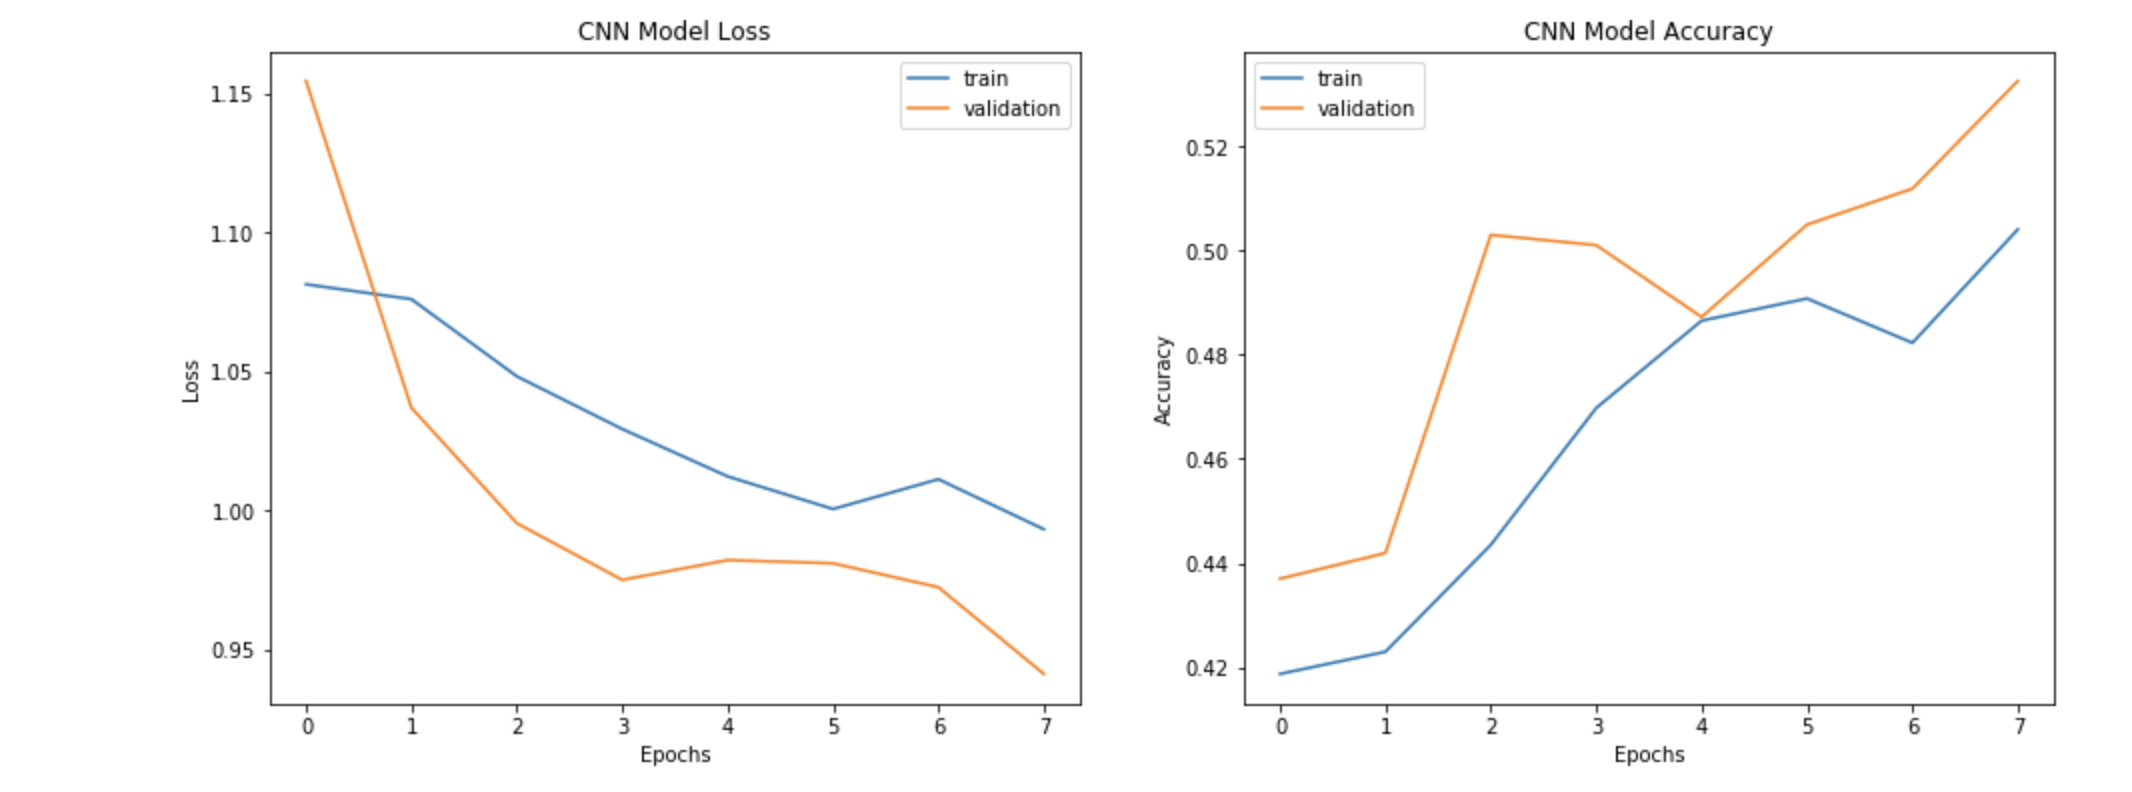

From these graphs, we found that the train accuracy is always below the validation accuracy, so we think there was an underfitting. Therefore, we trained CNN for a longer time (20 epoches) and the result is shown below.

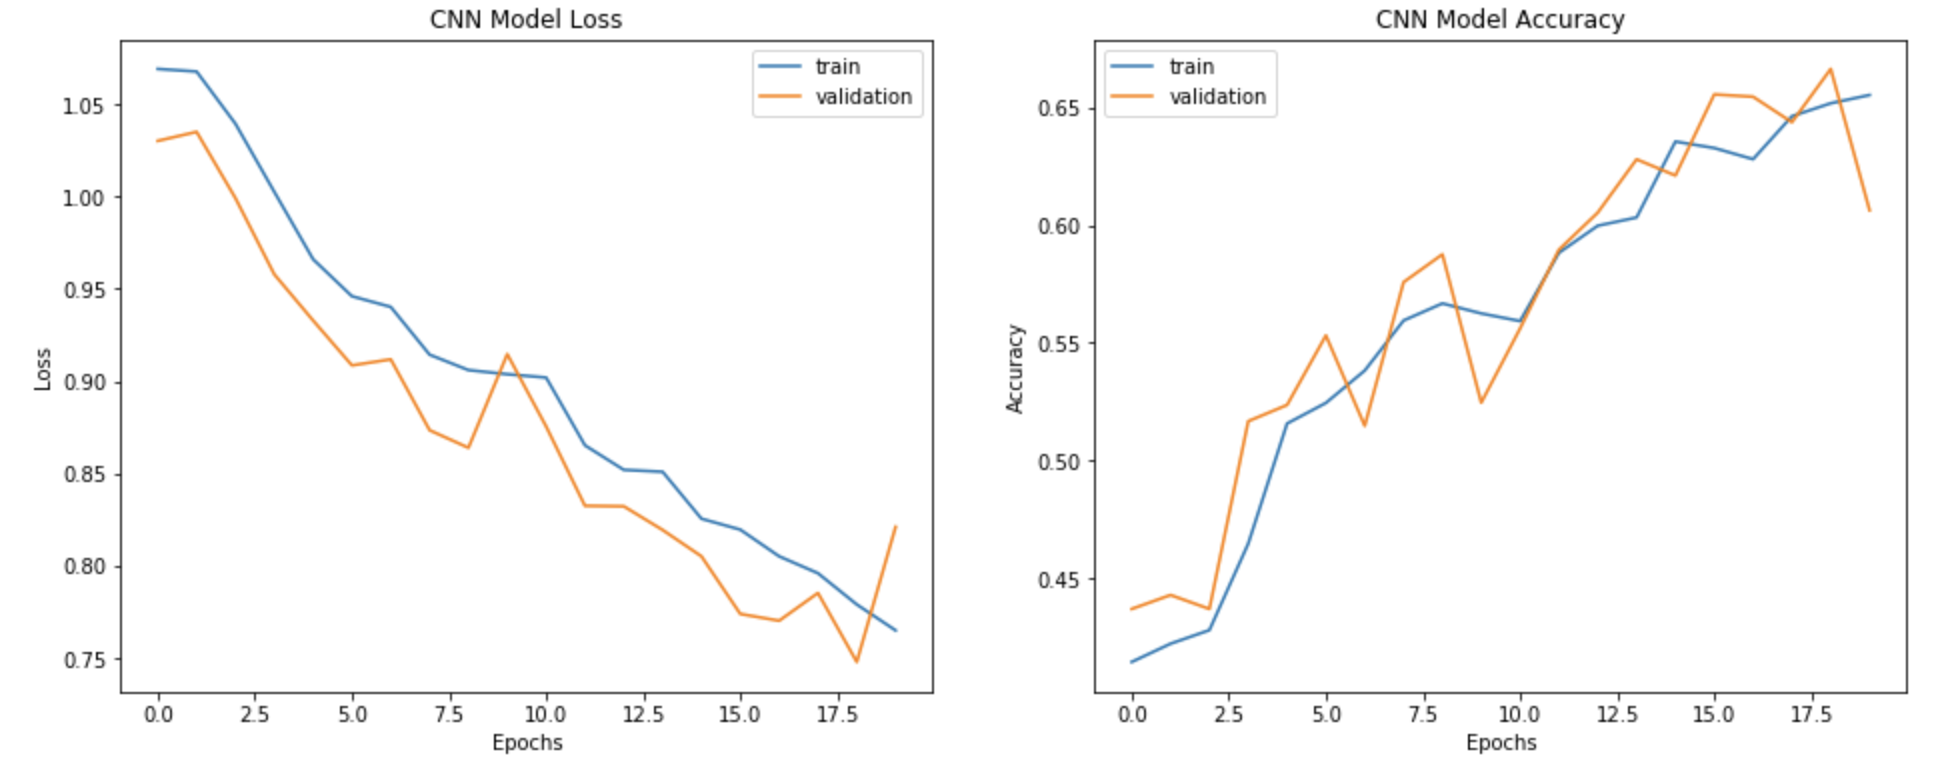

Next, we found that the highest validation accuracy occurred around 18 epoches. To save the training time, we finally decided to use 18 epoches to train our final CNN model and the process is shown below.

In [36]:
# Shuffle data to get training and validation dataset for further CNN&VGG16 use
X_train_shuf, y_train_shuf = shuffle(X_train, y_train_cat, random_state=1)

X_train = X_train_shuf[:4000]
X_val = X_train_shuf[4000:]

y_train_cat = y_train_shuf[:4000]
y_val_cat = y_train_shuf[4000:]

In [37]:
# Function to build CNN model
def build_cnn():
    
    # Initialize the CNN
    num_classes = 3
    model = Sequential()
    
    # Convolution
    model.add(Conv2D(64, kernel_size = 3, activation='relu', input_shape = (100, 100, 3)))
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Convolution layer
    model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(Conv2D(128, kernel_size = 5, strides=2, padding='same', activation='relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Convolution layer
    model.add(Conv2D(256, kernel_size = 4, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Flattening
    model.add(Flatten())
    model.add(Dropout(0.3))
    
    # Full connect
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [38]:
# Data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range = 0.25,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [39]:
# Train cnn model
cnn_model = build_cnn()

# Use adam optimizer and categorical cross entropy cost to evaluate the model
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn_history = cnn_model.fit_generator(datagen.flow(X_train, y_train_cat, batch_size=64), epochs = 18, validation_data=(X_val, y_val_cat), steps_per_epoch = X_train.shape[0]/64, verbose=1)

Epoch 1/18
63/62 [==============================] - ETA: 7:30 - loss: 1.0961 - accuracy: 0.31 - ETA: 5:41 - loss: 1.1065 - accuracy: 0.32 - ETA: 4:58 - loss: 1.0992 - accuracy: 0.35 - ETA: 4:33 - loss: 1.0919 - accuracy: 0.37 - ETA: 4:17 - loss: 1.0973 - accuracy: 0.37 - ETA: 4:00 - loss: 1.0925 - accuracy: 0.37 - ETA: 3:47 - loss: 1.0902 - accuracy: 0.37 - ETA: 3:39 - loss: 1.0911 - accuracy: 0.35 - ETA: 3:30 - loss: 1.0915 - accuracy: 0.36 - ETA: 3:26 - loss: 1.0926 - accuracy: 0.36 - ETA: 3:18 - loss: 1.0910 - accuracy: 0.37 - ETA: 3:11 - loss: 1.0902 - accuracy: 0.37 - ETA: 3:04 - loss: 1.0910 - accuracy: 0.37 - ETA: 2:58 - loss: 1.0882 - accuracy: 0.38 - ETA: 2:53 - loss: 1.0858 - accuracy: 0.38 - ETA: 2:47 - loss: 1.0823 - accuracy: 0.39 - ETA: 2:43 - loss: 1.0772 - accuracy: 0.39 - ETA: 2:38 - loss: 1.0769 - accuracy: 0.40 - ETA: 2:35 - loss: 1.0761 - accuracy: 0.40 - ETA: 2:31 - loss: 1.0766 - accuracy: 0.40 - ETA: 2:28 - loss: 1.0760 - accuracy: 0.40 - ETA: 2:24 - loss: 1.0734

63/62 [==============================] - ETA: 3:31 - loss: 0.8769 - accuracy: 0.54 - ETA: 3:28 - loss: 0.9011 - accuracy: 0.56 - ETA: 3:37 - loss: 0.8863 - accuracy: 0.57 - ETA: 3:32 - loss: 0.9131 - accuracy: 0.55 - ETA: 3:26 - loss: 0.9308 - accuracy: 0.53 - ETA: 3:21 - loss: 0.9444 - accuracy: 0.52 - ETA: 3:21 - loss: 0.9264 - accuracy: 0.53 - ETA: 3:17 - loss: 0.9325 - accuracy: 0.51 - ETA: 3:13 - loss: 0.9327 - accuracy: 0.52 - ETA: 3:09 - loss: 0.9244 - accuracy: 0.52 - ETA: 3:05 - loss: 0.9319 - accuracy: 0.50 - ETA: 3:01 - loss: 0.9250 - accuracy: 0.51 - ETA: 2:57 - loss: 0.9251 - accuracy: 0.51 - ETA: 2:53 - loss: 0.9266 - accuracy: 0.51 - ETA: 2:44 - loss: 0.9227 - accuracy: 0.51 - ETA: 2:40 - loss: 0.9202 - accuracy: 0.52 - ETA: 2:37 - loss: 0.9152 - accuracy: 0.53 - ETA: 2:33 - loss: 0.9178 - accuracy: 0.53 - ETA: 2:30 - loss: 0.9179 - accuracy: 0.53 - ETA: 2:27 - loss: 0.9230 - accuracy: 0.53 - ETA: 2:23 - loss: 0.9220 - accuracy: 0.53 - ETA: 2:20 - loss: 0.9233 - accuracy

63/62 [==============================] - ETA: 3:59 - loss: 0.8135 - accuracy: 0.62 - ETA: 3:49 - loss: 0.7808 - accuracy: 0.64 - ETA: 3:38 - loss: 0.8667 - accuracy: 0.59 - ETA: 3:36 - loss: 0.8943 - accuracy: 0.57 - ETA: 3:29 - loss: 0.8850 - accuracy: 0.58 - ETA: 3:24 - loss: 0.8986 - accuracy: 0.58 - ETA: 3:19 - loss: 0.9172 - accuracy: 0.58 - ETA: 3:14 - loss: 0.9041 - accuracy: 0.59 - ETA: 3:13 - loss: 0.9104 - accuracy: 0.58 - ETA: 3:11 - loss: 0.9208 - accuracy: 0.57 - ETA: 3:06 - loss: 0.9256 - accuracy: 0.56 - ETA: 3:01 - loss: 0.9223 - accuracy: 0.56 - ETA: 2:56 - loss: 0.9193 - accuracy: 0.57 - ETA: 2:56 - loss: 0.9215 - accuracy: 0.56 - ETA: 2:57 - loss: 0.9221 - accuracy: 0.56 - ETA: 2:54 - loss: 0.9163 - accuracy: 0.56 - ETA: 2:49 - loss: 0.9088 - accuracy: 0.57 - ETA: 2:44 - loss: 0.9168 - accuracy: 0.56 - ETA: 2:40 - loss: 0.9312 - accuracy: 0.56 - ETA: 2:35 - loss: 0.9339 - accuracy: 0.55 - ETA: 2:31 - loss: 0.9325 - accuracy: 0.55 - ETA: 2:28 - loss: 0.9289 - accuracy

63/62 [==============================] - ETA: 3:26 - loss: 0.9402 - accuracy: 0.54 - ETA: 3:37 - loss: 0.8832 - accuracy: 0.60 - ETA: 3:30 - loss: 0.8759 - accuracy: 0.59 - ETA: 3:33 - loss: 0.8651 - accuracy: 0.59 - ETA: 3:46 - loss: 0.8355 - accuracy: 0.61 - ETA: 3:42 - loss: 0.8326 - accuracy: 0.59 - ETA: 3:37 - loss: 0.8318 - accuracy: 0.60 - ETA: 3:29 - loss: 0.8239 - accuracy: 0.60 - ETA: 3:23 - loss: 0.8133 - accuracy: 0.61 - ETA: 3:17 - loss: 0.8003 - accuracy: 0.61 - ETA: 3:12 - loss: 0.8015 - accuracy: 0.61 - ETA: 3:07 - loss: 0.8042 - accuracy: 0.61 - ETA: 3:04 - loss: 0.8045 - accuracy: 0.62 - ETA: 2:59 - loss: 0.8038 - accuracy: 0.61 - ETA: 2:55 - loss: 0.8082 - accuracy: 0.61 - ETA: 2:50 - loss: 0.8177 - accuracy: 0.61 - ETA: 2:46 - loss: 0.8153 - accuracy: 0.61 - ETA: 2:42 - loss: 0.8131 - accuracy: 0.61 - ETA: 2:38 - loss: 0.8087 - accuracy: 0.61 - ETA: 2:34 - loss: 0.8012 - accuracy: 0.62 - ETA: 2:30 - loss: 0.7975 - accuracy: 0.62 - ETA: 2:27 - loss: 0.8002 - accuracy

63/62 [==============================] - ETA: 3:22 - loss: 0.8751 - accuracy: 0.62 - ETA: 3:29 - loss: 0.7905 - accuracy: 0.66 - ETA: 3:25 - loss: 0.7892 - accuracy: 0.65 - ETA: 3:23 - loss: 0.7953 - accuracy: 0.64 - ETA: 3:18 - loss: 0.7863 - accuracy: 0.66 - ETA: 3:15 - loss: 0.7744 - accuracy: 0.67 - ETA: 3:13 - loss: 0.7868 - accuracy: 0.66 - ETA: 3:10 - loss: 0.7774 - accuracy: 0.66 - ETA: 3:07 - loss: 0.7763 - accuracy: 0.66 - ETA: 3:05 - loss: 0.7700 - accuracy: 0.66 - ETA: 3:00 - loss: 0.7725 - accuracy: 0.65 - ETA: 2:57 - loss: 0.7684 - accuracy: 0.65 - ETA: 2:53 - loss: 0.7644 - accuracy: 0.65 - ETA: 2:49 - loss: 0.7678 - accuracy: 0.65 - ETA: 2:47 - loss: 0.7626 - accuracy: 0.66 - ETA: 2:44 - loss: 0.7631 - accuracy: 0.65 - ETA: 2:40 - loss: 0.7614 - accuracy: 0.65 - ETA: 2:36 - loss: 0.7697 - accuracy: 0.65 - ETA: 2:33 - loss: 0.7702 - accuracy: 0.65 - ETA: 2:30 - loss: 0.7675 - accuracy: 0.65 - ETA: 2:27 - loss: 0.7681 - accuracy: 0.65 - ETA: 2:24 - loss: 0.7795 - accuracy

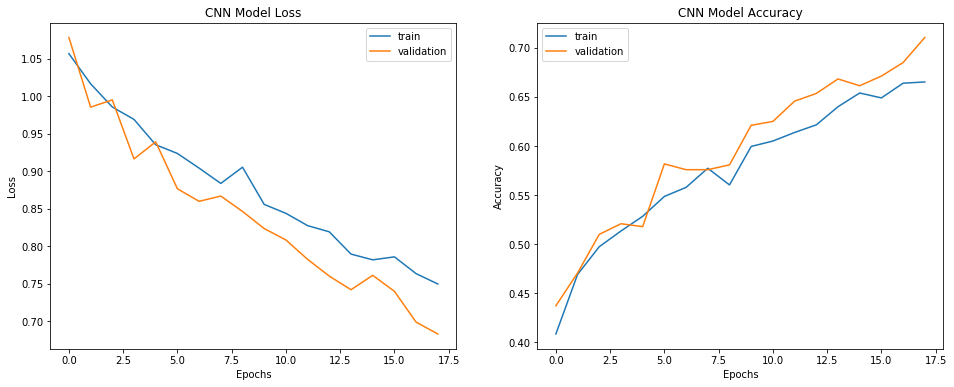

In [41]:
# Plot the results
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show();

In [42]:
# Evaluate test data predictions with cnn
cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test_cat, batch_size=64)

1254/1254 [==============================] - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 20s 16ms/step


In [43]:
# Test Error
print('The loss of test data is:', cnn_loss)
print('The accuray of test data is: %.2f%%' % (cnn_acc*100))

The loss of test data is: 0.669881756035715
The accuray of test data is: 71.53%


From above experiments, we can see that CNN has a much better performance than ANN in the first part, with test accuracy about $71.53\%$. CNN with $20$ epochs has a drop in validation accuracy after $18$th epoch,so we trained CNN only with $18$ epochs. Next, we will try some transfer learning before CNN and see how much the test accuracy can be improved.

### 3. VGG16

First, we trained VGG16 with 8 epochs, dropout = 0.3, the result is shown below. 

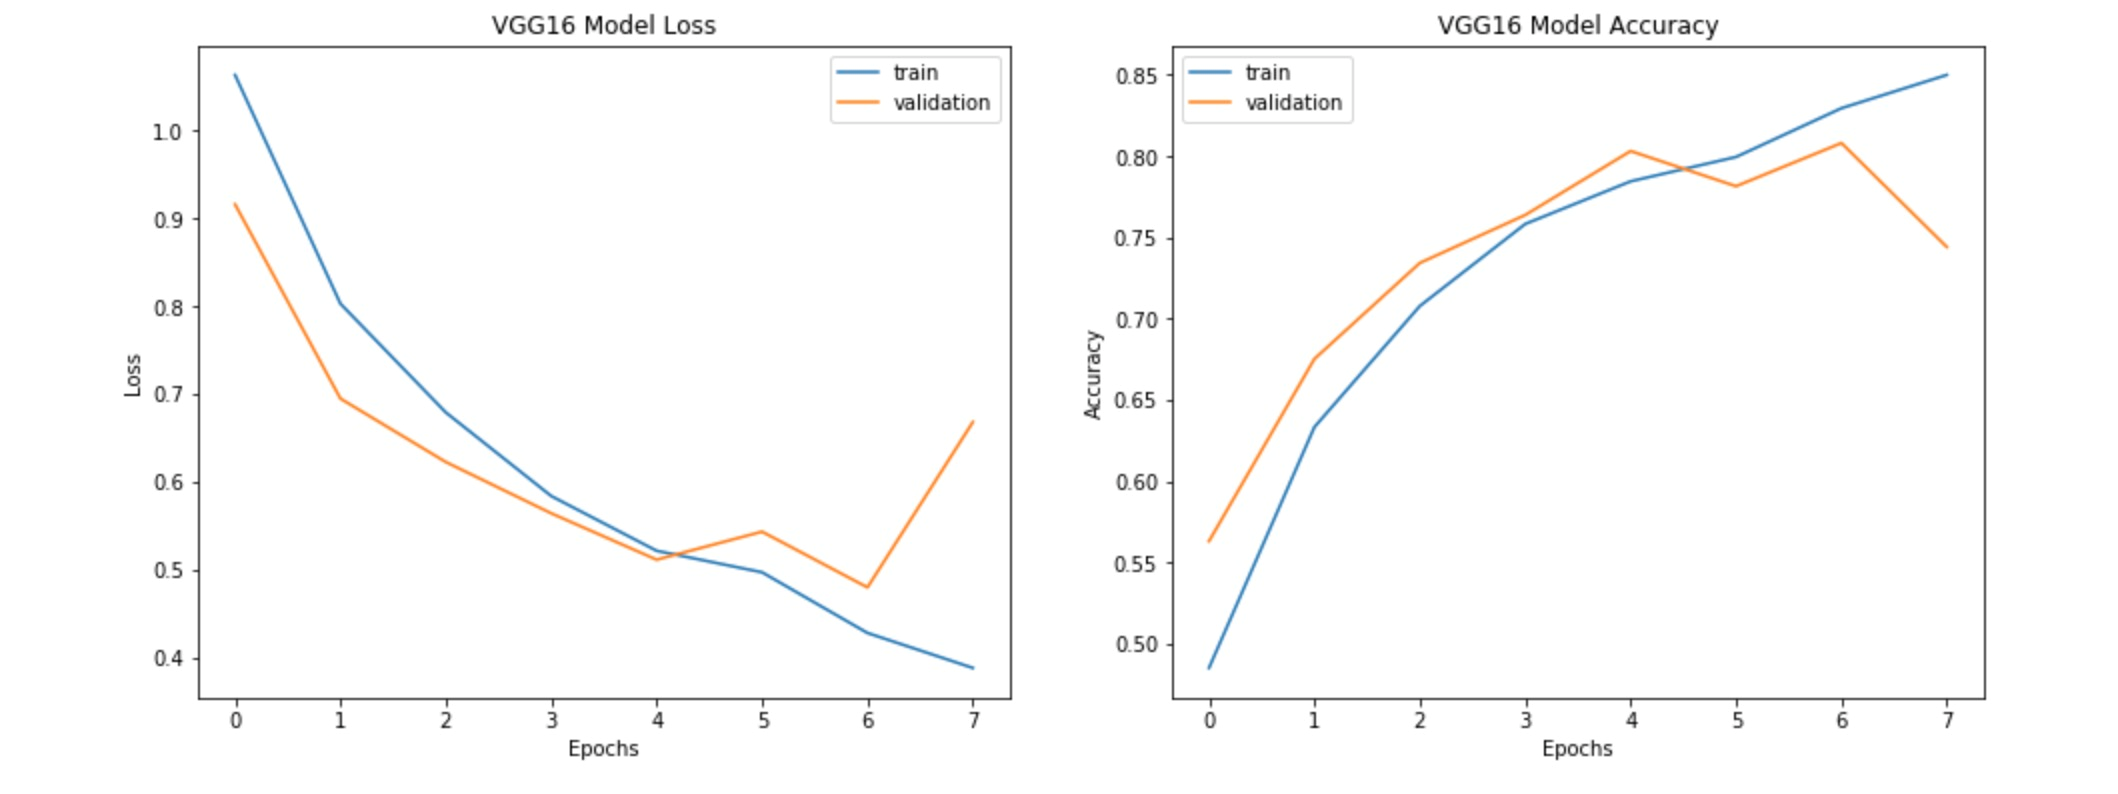

From this experiment, we found the test accuracy is 73.13%, which is close to the test accuracy by only using CNN. In order to improve the performance, we next trained VGG16 for a longer time (epochs=10) and decreased the dropout to 0.2.

In [44]:
# Initialize VGG16 model
image_input = Input(shape=(100, 100, 3))
vgg_mod = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')
vgg_mod.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [45]:
# Check Status
vgg_mod.trainable = False

for layer in vgg_mod.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    if layer.name == 'block4_conv1':
        layer.trainable = True    
    else:
        layer.trainable = False

vgg_mod.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [46]:
# Add model to VGG16
add_model = Sequential()
add_model.add(Flatten(input_shape=vgg_mod.output_shape[1:]))
add_model.add(Dense(512, activation= 'relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(3, activation='softmax'))

# Combine Models
model_vgg16 = Model(inputs=vgg_mod.input, outputs=add_model(vgg_mod.output))
model_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [47]:
# Train new VGG16 Model
callbacks_list = [ReduceLROnPlateau(monitor='loss',factor=0.2,patience=3)]

vgg_history=model_vgg16.fit(X_train, y_train_cat,
                       batch_size = 100,
                       epochs = 10, 
                       validation_data = (X_val, y_val_cat), 
                       callbacks = callbacks_list, 
                       verbose = 1)

Train on 4000 samples, validate on 1016 samples
Epoch 1/10
4000/4000 [==============================] - ETA: 6:06 - loss: 1.4041 - accuracy: 0.37 - ETA: 5:43 - loss: 2.0765 - accuracy: 0.38 - ETA: 5:33 - loss: 1.7701 - accuracy: 0.40 - ETA: 5:21 - loss: 1.6277 - accuracy: 0.39 - ETA: 5:14 - loss: 1.5273 - accuracy: 0.38 - ETA: 5:05 - loss: 1.4713 - accuracy: 0.38 - ETA: 4:55 - loss: 1.4214 - accuracy: 0.39 - ETA: 4:45 - loss: 1.3670 - accuracy: 0.40 - ETA: 4:35 - loss: 1.3486 - accuracy: 0.40 - ETA: 4:26 - loss: 1.3272 - accuracy: 0.41 - ETA: 4:17 - loss: 1.2980 - accuracy: 0.42 - ETA: 4:08 - loss: 1.2781 - accuracy: 0.41 - ETA: 4:06 - loss: 1.2483 - accuracy: 0.42 - ETA: 3:58 - loss: 1.2430 - accuracy: 0.41 - ETA: 3:52 - loss: 1.2195 - accuracy: 0.43 - ETA: 3:45 - loss: 1.2074 - accuracy: 0.43 - ETA: 3:35 - loss: 1.1905 - accuracy: 0.44 - ETA: 3:25 - loss: 1.1774 - accuracy: 0.44 - ETA: 3:15 - loss: 1.1619 - accuracy: 0.45 - ETA: 3:05 - loss: 1.1494 - accuracy: 0.46 - ETA: 2:56 - loss

4000/4000 [==============================] - ETA: 6:41 - loss: 0.1813 - accuracy: 0.89 - ETA: 6:15 - loss: 0.2491 - accuracy: 0.88 - ETA: 5:57 - loss: 0.2658 - accuracy: 0.87 - ETA: 5:44 - loss: 0.2450 - accuracy: 0.88 - ETA: 5:38 - loss: 0.2601 - accuracy: 0.88 - ETA: 5:26 - loss: 0.2526 - accuracy: 0.88 - ETA: 5:14 - loss: 0.2424 - accuracy: 0.89 - ETA: 5:04 - loss: 0.2407 - accuracy: 0.90 - ETA: 4:56 - loss: 0.2542 - accuracy: 0.89 - ETA: 4:47 - loss: 0.2522 - accuracy: 0.89 - ETA: 4:37 - loss: 0.2465 - accuracy: 0.89 - ETA: 4:26 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2570 - accuracy: 0.89 - ETA: 4:06 - loss: 0.2586 - accuracy: 0.89 - ETA: 3:56 - loss: 0.2608 - accuracy: 0.89 - ETA: 3:47 - loss: 0.2572 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2591 - accuracy: 0.89 - ETA: 3:28 - loss: 0.2633 - accuracy: 0.89 - ETA: 3:18 - loss: 0.2644 - accuracy: 0.89 - ETA: 3:09 - loss: 0.2630 - accuracy: 0.89 - ETA: 2:59 - loss: 0.2640 - accuracy: 0.89 - ETA: 2:51 - loss: 0.2606 - accu

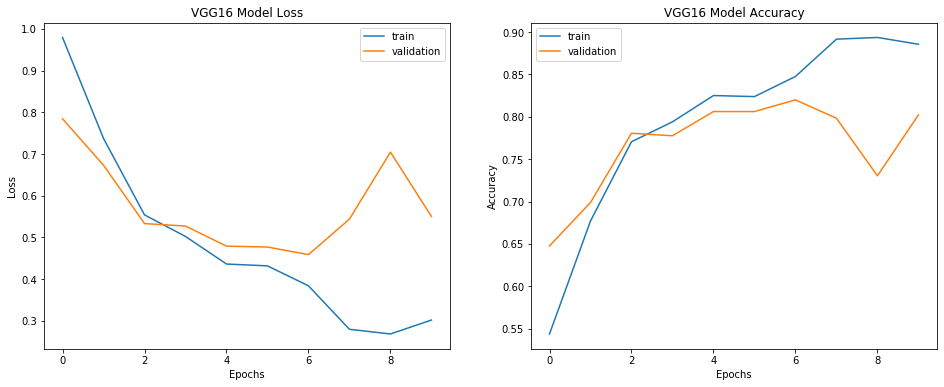

In [49]:
# Plot the results
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show();

In [50]:
# Evaluate VGG16 model
vgg_loss, vgg_acc = model_vgg16.evaluate(X_test, y_test_cat, verbose=0)

In [51]:
# Test Error
print('The loss of test data is:', vgg_loss)
print('The accuray of test data is: %.2f%%' % (vgg_acc*100))

The loss of test data is: 0.5352954312659907
The accuray of test data is: 80.94%


From above we can see that VGG16 performs very well, with test accuracy about $81\%$. But the results suugest optimal number of epoch should be $6$ for this case, we may try to fit it again in the future.

### Results Table

In [52]:
# Create result table for all the models
evaluation_list = [['ANN with 2 Layers', '-', accuracy_pred*100], 
                   ['ANN with 3 Layers', '-', accuracy_pred2*100],
                   ['CNN', cnn_loss, cnn_acc*100], 
                   ['VGG16', vgg_loss, vgg_acc*100]] 
    
evaluation = pd.DataFrame(evaluation_list, columns =['Model','Test Loss', 'Test Accuracy(%)'], dtype = float) 
evaluation

,Model,Test Loss,Test Accuracy(%)
0,ANN with 2 Layers,-,45.135566
1,ANN with 3 Layers,-,44.417863
2,CNN,0.669882,71.531099
3,VGG16,0.535295,80.940992


It turns out VGG16 has the best performance, so we decided to use this model to display some predicted cases.

#### Check some prediction results with VGG16

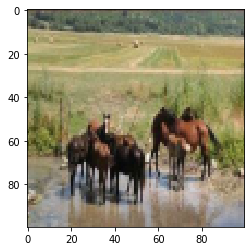

The actual lable is horse.
The predicted lable is cow.


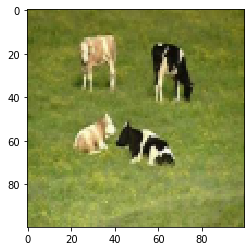

The actual lable is cow.
The predicted lable is cow.


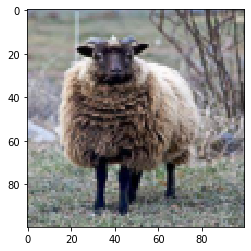

The actual label is sheep.
The predicted label is sheep.


In [53]:
# Select images
im_list = [100,400,900]

def helper1(array):
    maximum = max(array)
    if array.index(maximum) == 0:
        print('The actual lable is horse.')
    elif array.index(maximum) == 1:
        print('The actual lable is cow.')
    else:
        print('The actual label is sheep.')
        
def helper2(array):
    maximum = max(array)
    if array.index(maximum) == 0:
        print('The predicted lable is horse.')
    elif array.index(maximum) == 1:
        print('The predicted lable is cow.')
    else:
        print('The predicted label is sheep.')
        
for i in im_list:
    # Plot the image
    img = X_test[i]
    plt.imshow(img)
    plt.show()
    
    # Predict label by VGG16
    pred = model_vgg16.predict(img.reshape(1,100,100,3))
    actual =  y_test_cat[i]
    
    helper1(actual.tolist())
    helper2(pred.tolist()[0])

We found that this model would misclassify sheep as horse or horse as cow, because some of them have the same color and the images also have similar background (i.e., grass). It may perform better on other animals. Overall, our model is good.

In [55]:
# Save the models
cnn_model.save('animal_cnn.h5')
model_vgg16.save('animal_vgg.h5')